# Imports

In [1]:
import random
import json
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate

%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Player.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Street.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Utility.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Station.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Chance.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Tax.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Go.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Jail.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\FreeParking.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\GoToJail.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\CommunityChest.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\MonopolyBoard.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\Strategy.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\Simulation Classes\\RandomStrategy.py"

%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\MonopolyBoardMCTS.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\Node.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\MCTS.py"
%run -i "C:\\Users\\cathe\\OneDrive\\Documents\\Capstone - Optimising Monopoly Gameplay Strategies\\MCTS\\State.py"

random.seed(42)

# Game Rollouts - Random Strategy (OLD)

In [4]:
def game():
    # create board and add players
    board = MonopolyBoardMCTS()
    agent = Player('Agent')
    player = Player('Player')
    board.add_agent(agent)
    board.add_other_player(player)

    # using a random strategy
    strategy = RandomStrategy()
    board.strategy = strategy

    # run MCTS game
    root_state = State()
    root_state.from_monopoly_board(board)
    mcts = MCTS(root_state, max_iterations=500, exploration_weight=1, max_simulations=5)
    mcts.run_game(max_rounds=20)

    return mcts.root.state.rounds, mcts.root.state.agent, mcts.root.state.other_players[0], \
        mcts.root.state.properties, mcts.root.state.stations, mcts.root.state.utilities, mcts.root.state.agent_wealth, \
        mcts.root.state.other_players_wealth

In [7]:
random.seed(42)
num_games = 5
game_outcomes = {'Rounds': [], 'Agent': [], 'Other player(s)': [], 'Properties': [], 'Stations': [], 'Utilities': [], 'Agent Wealth': [], 
                 'Other Player(s) Wealth': []}

for _ in range(num_games):
    rounds, agent, other_players, properties, stations, utilities, agent_wealth, other_players_wealth = game()
    game_outcomes['Rounds'].append(rounds)
    game_outcomes['Agent'].append(agent)
    game_outcomes['Other player(s)'].append(other_players)
    game_outcomes['Properties'].append(properties)
    game_outcomes['Stations'].append(stations)
    game_outcomes['Utilities'].append(utilities)
    game_outcomes['Agent Wealth'].append(agent_wealth)
    game_outcomes['Other Player(s) Wealth'].append(other_players_wealth)

Running MCTS game:   6%|▌         | 60/1000 [00:14<03:43,  4.21it/s]


In [ ]:
file_path = 'MCTS_RandomStrategy_MaxRounds20_1000_game_outcomes.json'
with open(file_path, 'w') as json_file:
    json.dump(game_outcomes, json_file, indent=4)

## Analysing Game Rollouts

In [2]:
file_path = 'MCTS_RandomStrategy_100_game_outcomes.json'
with open(file_path, 'r') as json_file:
    game_outcomes = json.load(json_file)

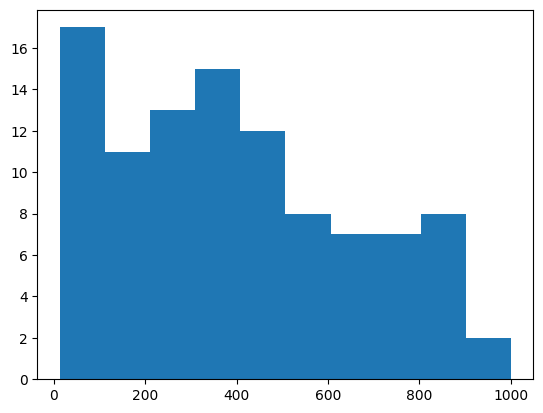

In [3]:
plt.hist(game_outcomes['Rounds'])
plt.show()

In [4]:
agent_losses = sum([agent[3] for agent in game_outcomes['Agent']])
agent_wins = sum([agent[3] for agent in game_outcomes['Other player(s)']])
game_not_ended = 100 - agent_losses - agent_wins

print(f'Out of 100 games with 2 players, run for 1000 decisions, using a random strategy, the agent won \n {agent_wins} games, the other player won {agent_losses} games. The other {game_not_ended} games did not end in this time period.')

Out of 100 games with 2 players, run for 1000 decisions, using a random strategy, the agent won 
 23 games, the other player won 3 games. The other 74 games did not end in this time period.


In [8]:
street_data = [
            ("Old Kent Road", 60, 50, 2, 10, 30, 90, 160, 250, 1, "brown", 2),
            ("Whitechapel Road", 60, 50, 4, 20, 60, 180, 320, 450, 3, "brown", 2),
            ("The Angel Islington", 100, 50, 6, 30, 90, 270, 400, 550, 6, "lightblue", 3),
            ("Euston Road", 100, 50, 6, 30, 90, 270, 400, 550, 8, "lightblue", 3),
            ("Pentonville Road", 120, 50, 8, 40, 100, 300, 450, 600, 9, "lightblue", 3),
            ("Pall Mall", 140, 100, 10, 50, 150, 450, 625, 750, 11, "pink", 3),
            ("Whitehall", 140, 100, 10, 50, 150, 450, 625, 750, 13, "pink", 3),
            ("Northumberland Avenue", 160, 100, 12, 60, 180, 500, 700, 900, 14, "pink", 3),
            ("Bow Street", 180, 100, 14, 70, 200, 550, 750, 950, 16, "orange", 3),
            ("Marlborough Street", 180, 100, 14, 70, 200, 550, 750, 950, 18, "orange", 3),
            ("Vine Street", 200, 100, 16, 80, 220, 600, 800, 1000, 19, "orange", 3),
            ("The Strand", 220, 150, 18, 90, 250, 700, 875, 1050, 21, "red", 3),
            ("Fleet Street", 220, 150, 18, 90, 250, 700, 875, 1050, 23, "red", 3),
            ("Trafalgar Square", 240, 150, 20, 100, 300, 750, 925, 1100, 24, "red", 3),
            ("Leicester Square", 260, 150, 22, 110, 330, 800, 975, 1150, 26, "yellow", 3),
            ("Coventry Street", 260, 150, 22, 110, 330, 800, 975, 1150, 27, "yellow", 3),
            ("Piccadilly", 280, 150, 24, 120, 360, 850, 1025, 1200, 29, "yellow", 3),
            ("Regent Street", 300, 200, 26, 130, 390, 900, 1100, 1275, 31, "green", 3),
            ("Oxford Street", 300, 200, 26, 130, 390, 900, 1100, 1275, 32, "green", 3),
            ("Bond Street", 320, 200, 28, 150, 450, 1000, 1200, 1400, 34, "green", 3),
            ("Park Lane", 350, 200, 35, 175, 500, 1100, 1300, 1500, 37, "darkblue", 2),
            ("Mayfair", 400, 200, 50, 200, 600, 1400, 1700, 2000, 39, "darkblue", 2)
        ]

In [17]:
# wealth: money, properties (mortgaged/unmortgaged + buildings)
agent_wealth = []
player_wealth = []

for idx in range(100):
    money_agent = game_outcomes['Agent'][idx][2]
    money_player = game_outcomes['Other player(s)'][idx][2]

    for idx, prop in enumerate(game_outcomes['Properties'][idx]):
        if prop[0] == 'Agent':
            if prop[3]:
                money_agent += street_data[idx][1]/2
            else:
                money_agent += street_data[idx][1]

            money_agent += street_data[idx][2] * (prop[1]+prop[2])

        elif prop[0] == 'Player':
            if prop[3]:
                money_player += street_data[idx][1]/2
            else:
                money_player += street_data[idx][1]

            money_player += street_data[idx][2] * (prop[1]+prop[2])

    agent_wealth.append(money_agent)
    player_wealth.append(money_player)

In [16]:
property_names = [
    "Old Kent Road",
    "Whitechapel Road",
    "The Angel Islington",
    "Euston Road",
    "Pentonville Road",
    "Pall Mall",
    "Whitehall",
    "Northumberland Avenue",
    "Bow Street",
    "Marlborough Street",
    "Vine Street",
    "Strand",
    "Fleet Street",
    "Trafalgar Square",
    "Leicester Square",
    "Coventry Street",
    "Piccadilly",
    "Regent Street",
    "Oxford Street",
    "Bond Street",
    "Park Lane",
    "Mayfair",
    "King's Cross Station",
    "Marylebone Station",
    "Fenchurch Street Station",
    "Liverpool Street Station",
    "Electric Company",
    "Water Works"
]

In [257]:
props_bought_player = [0]*28
props_bought_agent = [0]*28

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx] += 0.01
        elif prop[0] == 'Agent':
            props_bought_agent[idx] += 0.01
        else:
            pass

for game in game_outcomes['Stations']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx+22] += 0.01
        elif prop[0] == 'Agent':
            props_bought_agent[idx+22] += 0.01
        else:
            pass

for game in game_outcomes['Utilities']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx+26] += 0.01
        elif prop[0] == 'Agent':
            props_bought_agent[idx+26] += 0.01
        else:
            pass

In [258]:
def wilson_score_interval(p, n, z):
    z_squared = z**2
    phat = p + z_squared / (2 * n)
    margin_of_error = z * np.sqrt((p * (1 - p) / n) + z_squared / (4 * n))
    
    ci_lower = (phat - margin_of_error) / (1 + z_squared / n)
    ci_upper = (phat + margin_of_error) / (1 + z_squared / n)
    
    return ci_lower, ci_upper


In [259]:
def interval_property_plot(agent, player, ylabel, ylim0=0, ylim1=1):
    num_points = len(agent)
    ci_lower_props_bought_player = [0]*num_points
    ci_lower_props_bought_agent = [0]*num_points
    ci_upper_props_bought_player = [0]*num_points
    ci_upper_props_bought_agent = [0]*num_points

    z = norm.ppf(0.975)
    n = 100

    for idx, p in enumerate(player):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_player[idx] = ci_lower
        ci_upper_props_bought_player[idx] = ci_upper

    for idx, p in enumerate(agent):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_agent[idx] = ci_lower
        ci_upper_props_bought_agent[idx] = ci_upper

    x = range(num_points)
    plt.figure(figsize=(15, 8))

    vertical_lines = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5]
    for i in range(len(vertical_lines)):
        plt.axvline(vertical_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    if num_points > 22:
        vertical_lines = [21.5, 25.5]
        for i in range(len(vertical_lines)):
            plt.axvline(vertical_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    horizontal_lines = [0.2, 0.4, 0.6, 0.8]
    for i in range(len(horizontal_lines)):
        plt.axhline(horizontal_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    plt.fill_between(x, ci_lower_props_bought_player, ci_upper_props_bought_player, color='lightblue', alpha=0.5)
    plt.fill_between(x, ci_lower_props_bought_agent, ci_upper_props_bought_agent, color='pink', alpha=0.5)
    plt.scatter(x, player, alpha = 0.5, color = 'blue', label = 'Player')
    plt.scatter(x, agent, alpha = 0.5, color = 'red', label = 'Agent')
        
    plt.xticks(x, property_names[:num_points], rotation = 90)
    plt.xlabel('Property')
    plt.ylabel(ylabel)
    
    plt.ylim(ylim0, ylim1)
    plt.legend()
    plt.show()

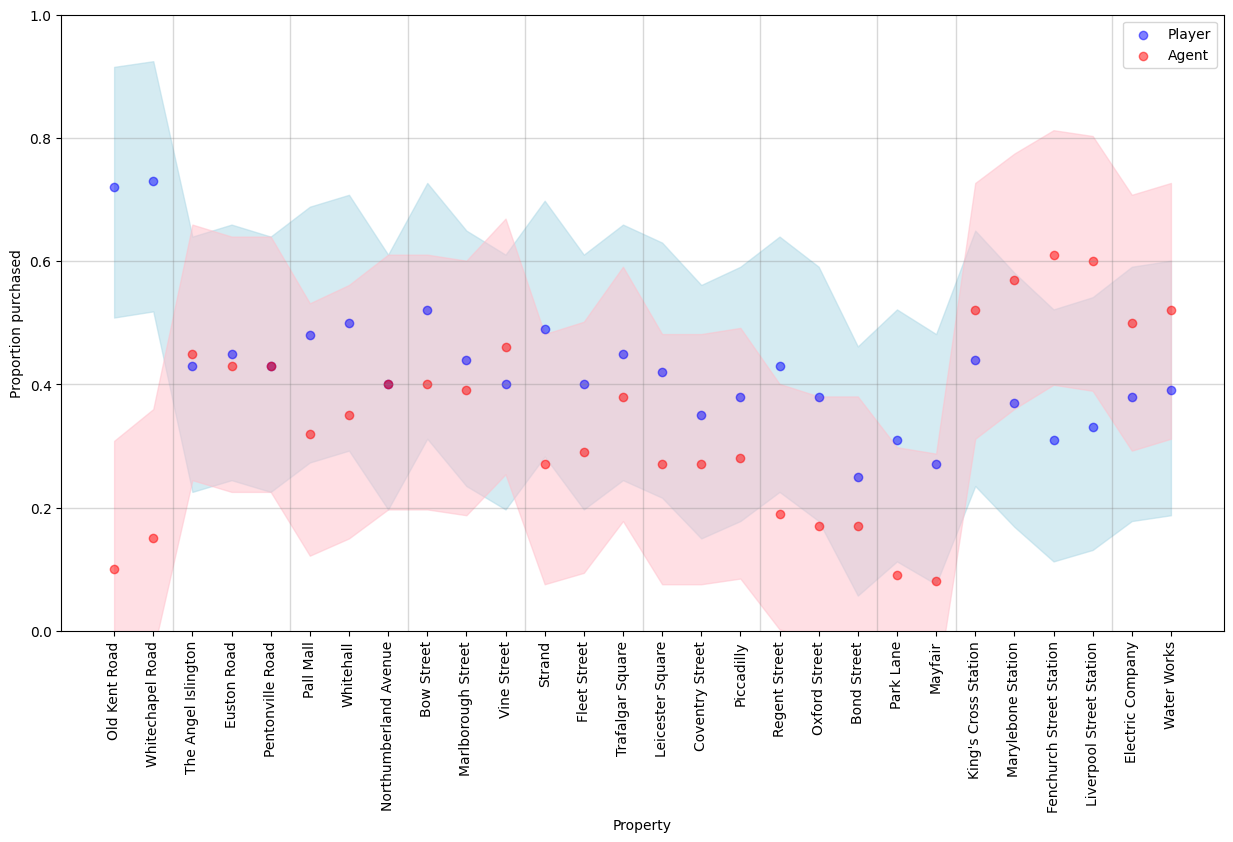

In [260]:
interval_property_plot(props_bought_player, props_bought_agent, 'Proportion purchased')

In [261]:
def interval_whiskers_property_plot(agent, player):
    ci_lower_props_bought_player = [0]*28
    ci_lower_props_bought_agent = [0]*28
    ci_upper_props_bought_player = [0]*28
    ci_upper_props_bought_agent = [0]*28

    z = norm.ppf(0.975)
    n = 100

    for idx, p in enumerate(player):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_player[idx] = p - ci_lower
        ci_upper_props_bought_player[idx] = ci_upper - p

    for idx, p in enumerate(agent):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_agent[idx] = p - ci_lower
        ci_upper_props_bought_agent[idx] = ci_upper - p

    x = range(28)
    plt.figure(figsize=(15, 8))

    vertical_lines = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 21.5, 25.5]
    for i in range(9):
        plt.axvline(vertical_lines[i], alpha = 0.5, color = 'gray', linewidth = 1)

    horizontal_lines = [0.2, 0.4, 0.6, 0.8]
    for i in range(len(horizontal_lines)):
        plt.axhline(horizontal_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    plt.errorbar(x, props_bought_player, yerr=[ci_lower_props_bought_player, ci_upper_props_bought_player], alpha = 0.5, fmt='o', color='blue', capsize=5, label='Player')
    plt.errorbar(x, props_bought_agent, yerr=[ci_lower_props_bought_agent, ci_upper_props_bought_agent], alpha = 0.5, fmt='o', color='red', capsize=5, label='Agent')
        
    plt.xticks(x, property_names, rotation = 90)
    plt.ylim(0, 1)
    plt.xlabel('Property')
    plt.ylabel('Proportion Purchased')
    plt.gca().xaxis.grid(False)
    plt.legend()
    plt.show()

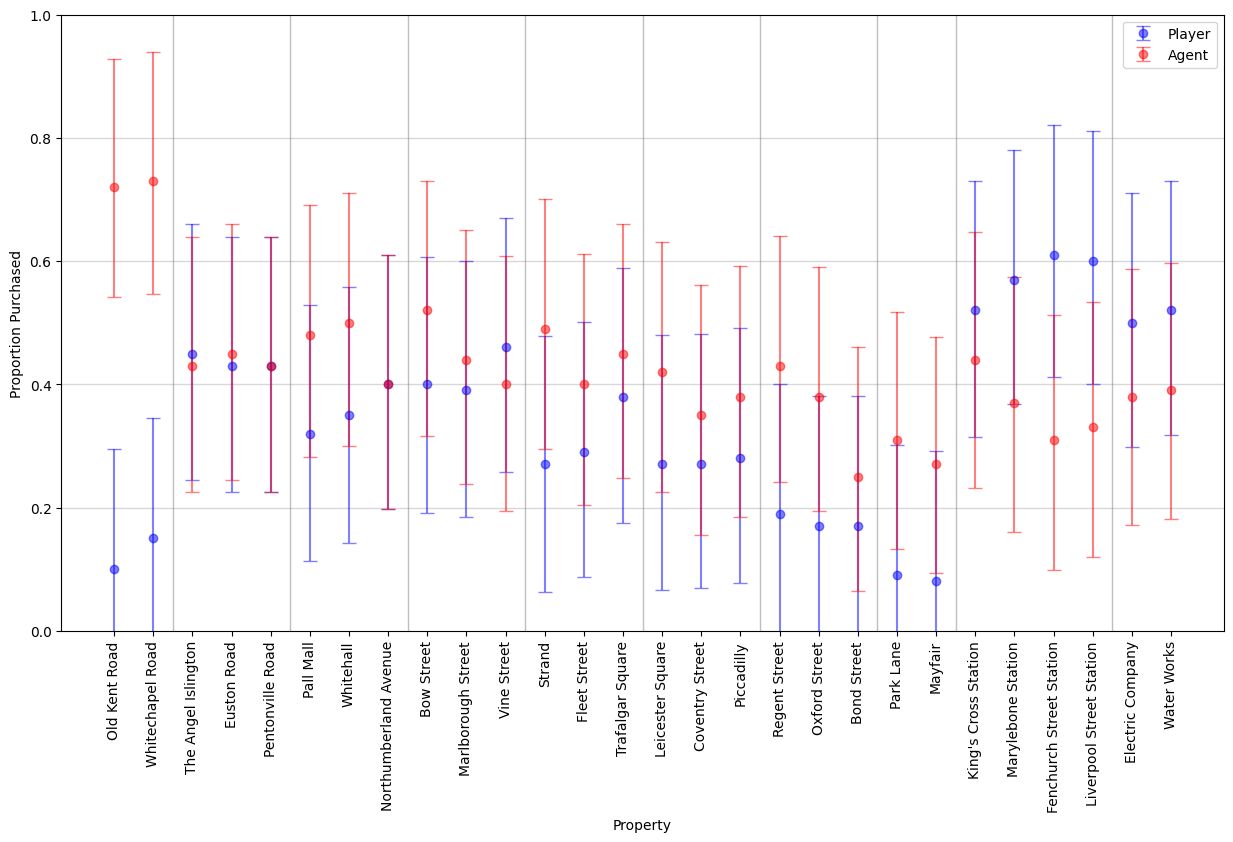

In [262]:
interval_whiskers_property_plot(props_bought_player, props_bought_agent)

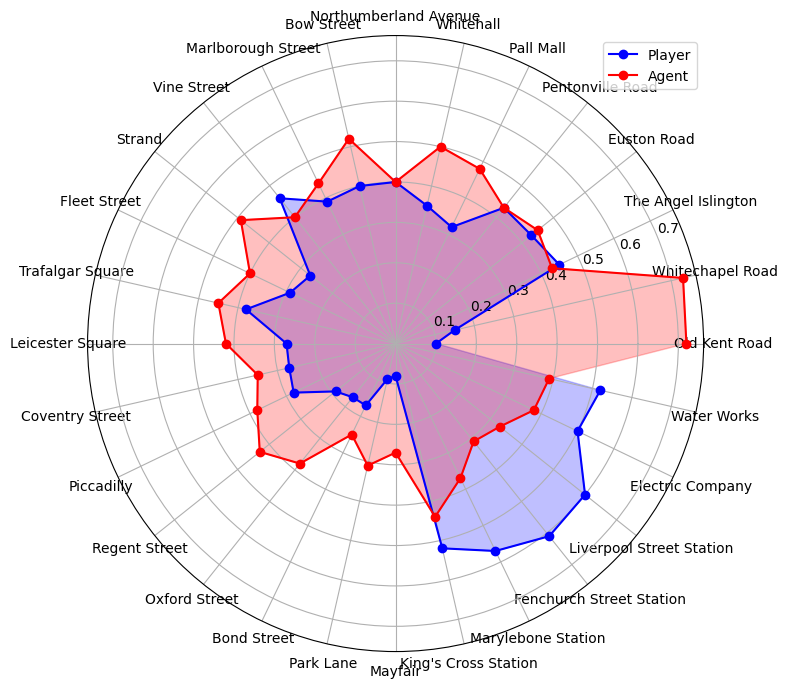

In [263]:
theta = np.linspace(0, 2 * np.pi, len(props_bought_player), endpoint=False)

plt.figure(figsize=(8, 8))
plt.subplot(111, polar=True)

plt.plot(theta, props_bought_player, 'o-', color='blue', label='Player')
plt.plot(theta, props_bought_agent, 'o-', color='red', label='Agent')
plt.fill(theta, props_bought_player, color='blue', alpha=0.25)
plt.fill(theta, props_bought_agent, color='red', alpha=0.25)
plt.thetagrids(np.arange(0, 360, 360 / len(property_names)), labels=property_names)
plt.legend()
plt.show()

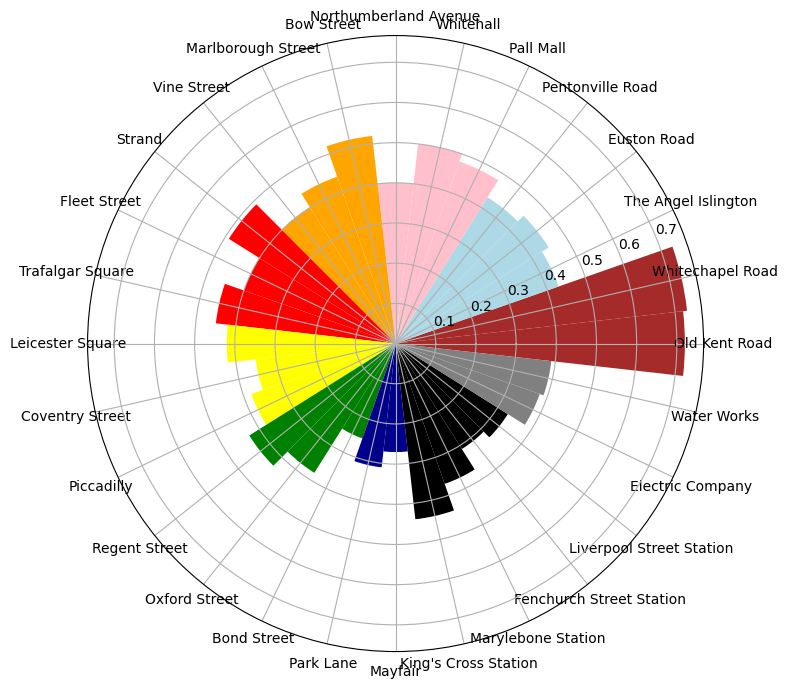

In [264]:
bar_colours = ['brown', 'brown', 'lightblue', 'lightblue', 'lightblue', 'pink', 'pink', 'pink',
               'orange', 'orange', 'orange', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 
               'green', 'green', 'green', 'darkblue', 'darkblue', 'black', 'black', 'black',
               'black', 'grey', 'grey']

theta = np.linspace(0, 2 * np.pi, len(props_bought_agent), endpoint=False)

plt.figure(figsize=(8, 8))
plt.subplot(111, polar=True)

width = 2 * np.pi / len(props_bought_agent)

for i in range(len(props_bought_agent)):
    plt.bar(theta[i], props_bought_agent[i], width=width, color=bar_colours[i])

plt.thetagrids(np.arange(0, 360, 360 / len(property_names)), labels=property_names)
plt.show()

In [265]:
num_props_bought_agent = [0] * 100
num_props_bought_player = [0] * 100

for idx, game in enumerate(game_outcomes['Properties']):
    for prop in game:
        if prop[0] == 'Agent':
            num_props_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_props_bought_player[idx] += 1
        else:
            pass

In [266]:
np.mean(num_props_bought_agent)

9.63

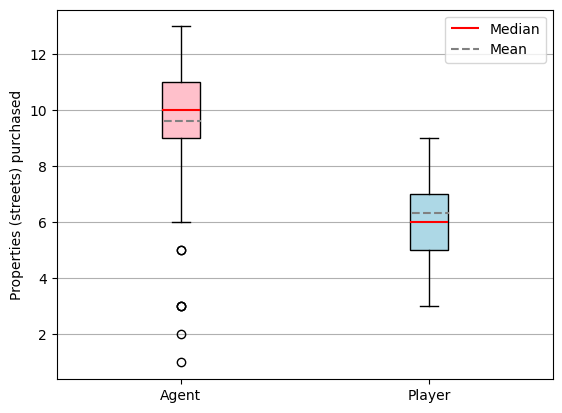

In [267]:
fig, ax = plt.subplots()
box = ax.boxplot([num_props_bought_agent, num_props_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=1.5, label='Median')
box['medians'][1].set(color='red', linewidth=1.5)

ax.set_xticks([1, 2])
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_props_bought_agent), np.mean(num_props_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_props_bought_player), np.mean(num_props_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Properties (streets) purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [268]:
num_stations_bought_agent = [0] * 100
num_stations_bought_player = [0] * 100

for idx, game in enumerate(game_outcomes['Stations']):
    for prop in game:
        if prop[0] == 'Agent':
            num_stations_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_stations_bought_player[idx] += 1
        else:
            pass

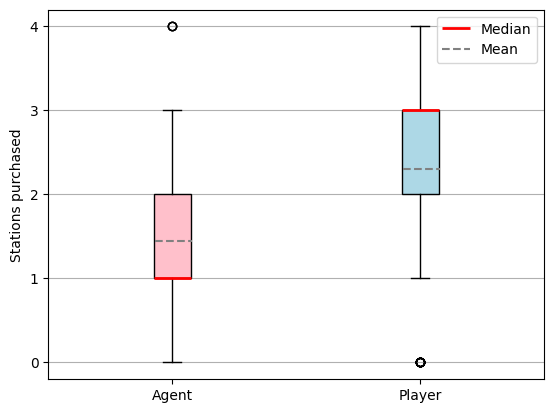

In [269]:
fig, ax = plt.subplots()
box = ax.boxplot([num_stations_bought_agent, num_stations_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=2, label='Median')
box['medians'][1].set(color='red', linewidth=2)

ax.set_xticks([1, 2])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_stations_bought_agent), np.mean(num_stations_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_stations_bought_player), np.mean(num_stations_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Stations purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [270]:
num_utilities_bought_agent = [0] * 100
num_utilities_bought_player = [0] * 100

for idx, game in enumerate(game_outcomes['Utilities']):
    for prop in game:
        if prop[0] == 'Agent':
            num_utilities_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_utilities_bought_player[idx] += 1
        else:
            pass

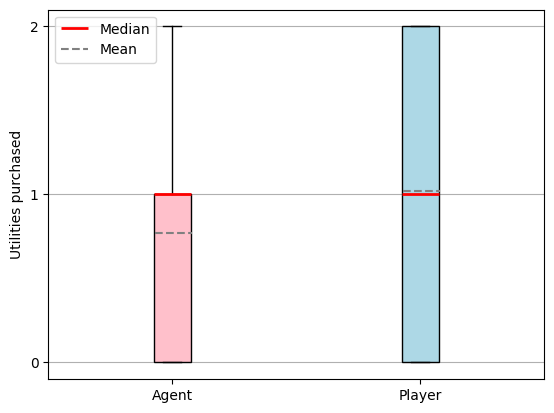

In [271]:
fig, ax = plt.subplots()
box = ax.boxplot([num_utilities_bought_agent, num_utilities_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=2, label='Median')
box['medians'][1].set(color='red', linewidth=2)

ax.set_xticks([1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_utilities_bought_agent), np.mean(num_utilities_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_utilities_bought_player), np.mean(num_utilities_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Utilities purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [272]:
houses_bought_player_1 = [0]*22
houses_bought_agent_1 = [0]*22
houses_bought_player_2 = [0]*22
houses_bought_agent_2 = [0]*22
houses_bought_player_3 = [0]*22
houses_bought_agent_3 = [0]*22
houses_bought_player_4 = [0]*22
houses_bought_agent_4 = [0]*22
hotels_bought_player = [0]*22
hotels_bought_agent = [0]*22
built_player = [0]*22
built_agent = [0]*22

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            if prop[1] > 0 or prop[2]:
                built_player[idx] += 0.01

            if prop[1] == 1:
                houses_bought_player_1[idx] += 0.01
            elif prop[1] == 2:
                houses_bought_player_2[idx] += 0.01
            elif prop[1] == 3:
                houses_bought_player_3[idx] += 0.01
            elif prop[1] == 4:
                houses_bought_player_4[idx] += 0.01
            elif prop[2]:
                hotels_bought_player[idx] += 0.01
            else:
                pass
        elif prop[0] == 'Agent':
            if prop[1] > 0 or prop[2]:
                built_agent[idx] += 0.01

            if prop[1] == 1:
                houses_bought_agent_1[idx] += 0.01
            elif prop[1] == 2:
                houses_bought_agent_2[idx] += 0.01
            elif prop[1] == 3:
                houses_bought_agent_3[idx] += 0.01
            elif prop[1] == 4:
                houses_bought_agent_4[idx] += 0.01
            elif prop[2]:
                hotels_bought_agent[idx] += 0.01
            else:
                pass
        else:
            pass

In [273]:
houses_bought_player_1_normalised = [houses_bought_player_1[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_1_normalised = [houses_bought_agent_1[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_2_normalised = [houses_bought_player_2[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_2_normalised = [houses_bought_agent_2[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_3_normalised = [houses_bought_player_3[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_3_normalised = [houses_bought_agent_3[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_4_normalised = [houses_bought_player_4[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_4_normalised = [houses_bought_agent_4[i]/props_bought_agent[i] for i in range(22)]
hotels_bought_player_normalised = [hotels_bought_player[i]/props_bought_player[i] for i in range(22)]
hotels_bought_agent_normalised = [hotels_bought_agent[i]/props_bought_agent[i] for i in range(22)]
built_player_normalised = [built_player[i]/props_bought_agent[i] for i in range(22)]
built_agent_normalised = [built_agent[i]/props_bought_agent[i] for i in range(22)]

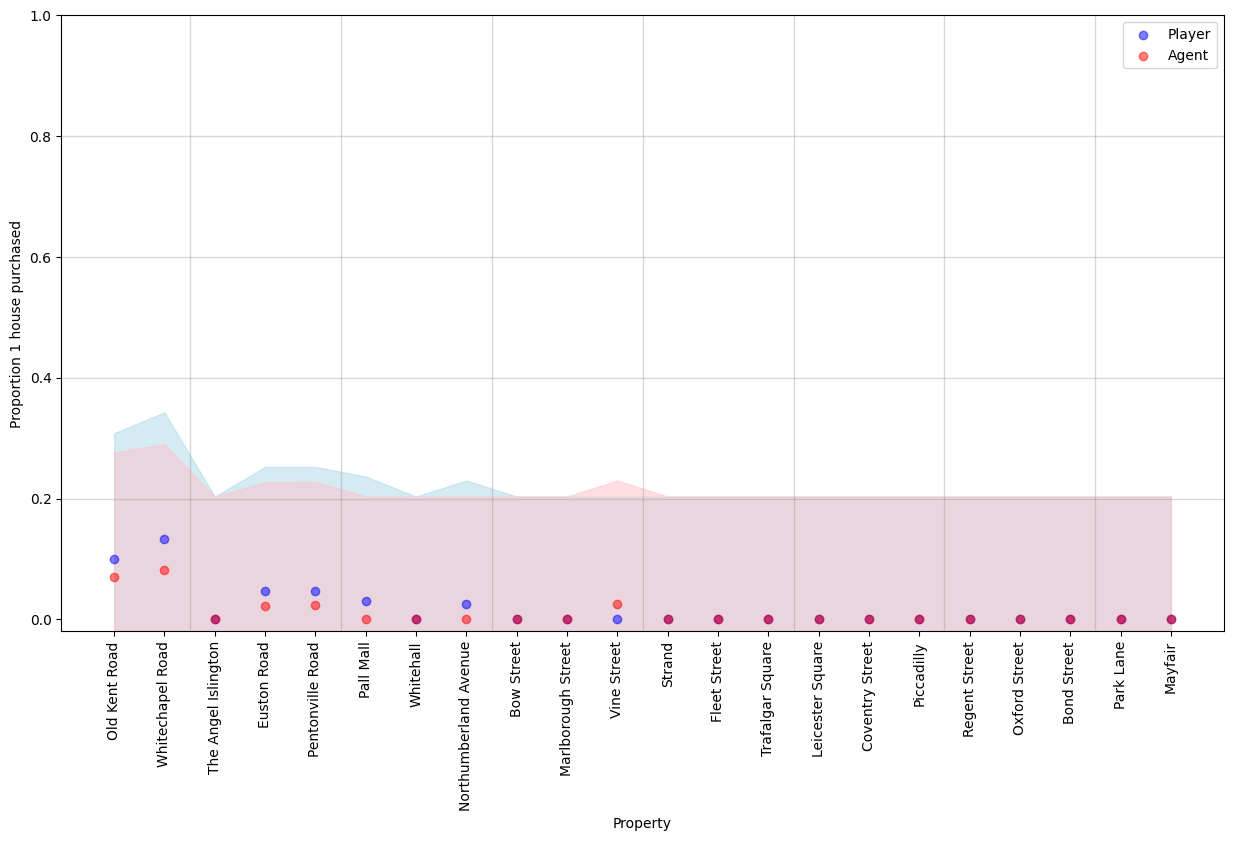

In [274]:
interval_property_plot(houses_bought_agent_1_normalised, houses_bought_player_1_normalised, 'Proportion 1 house purchased', -0.02, 1)

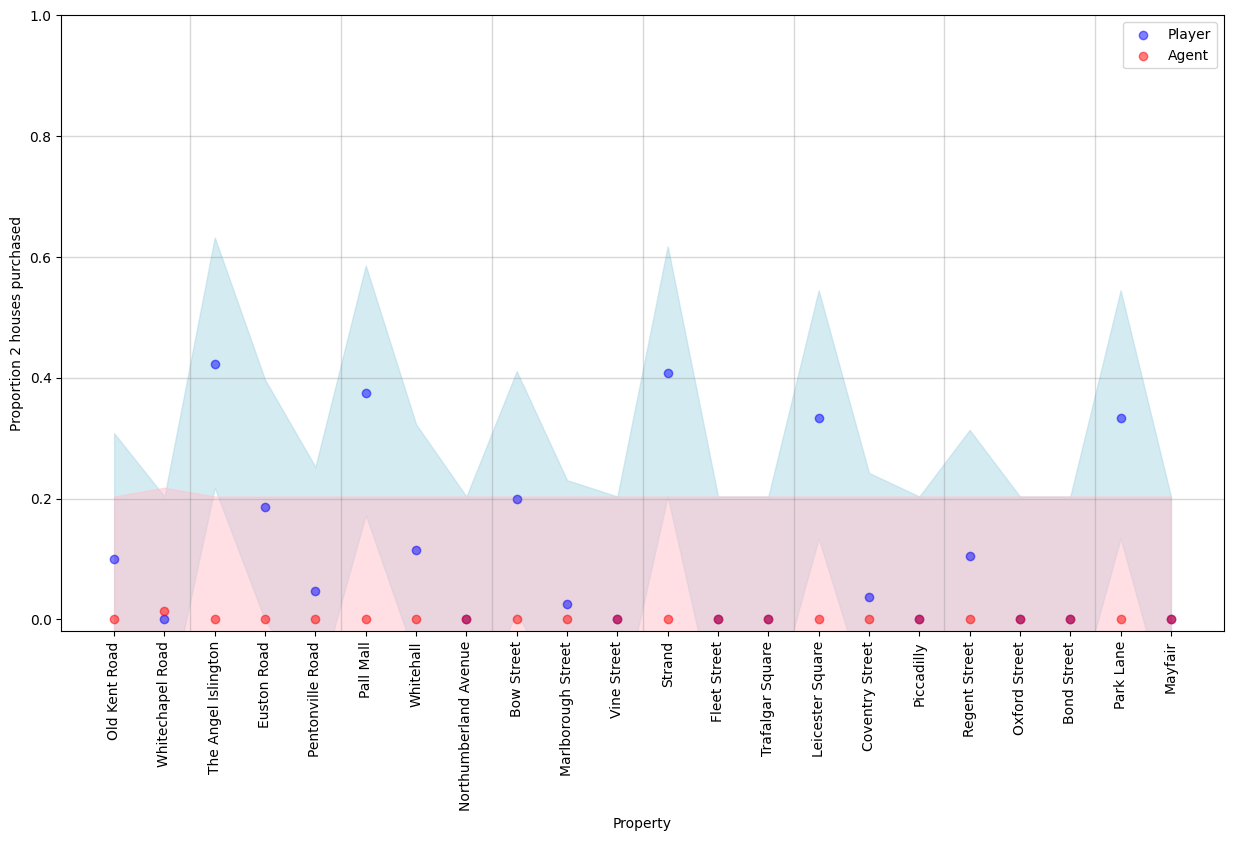

In [275]:
interval_property_plot(houses_bought_agent_2_normalised, houses_bought_player_2_normalised, 'Proportion 2 houses purchased', -0.02, 1)

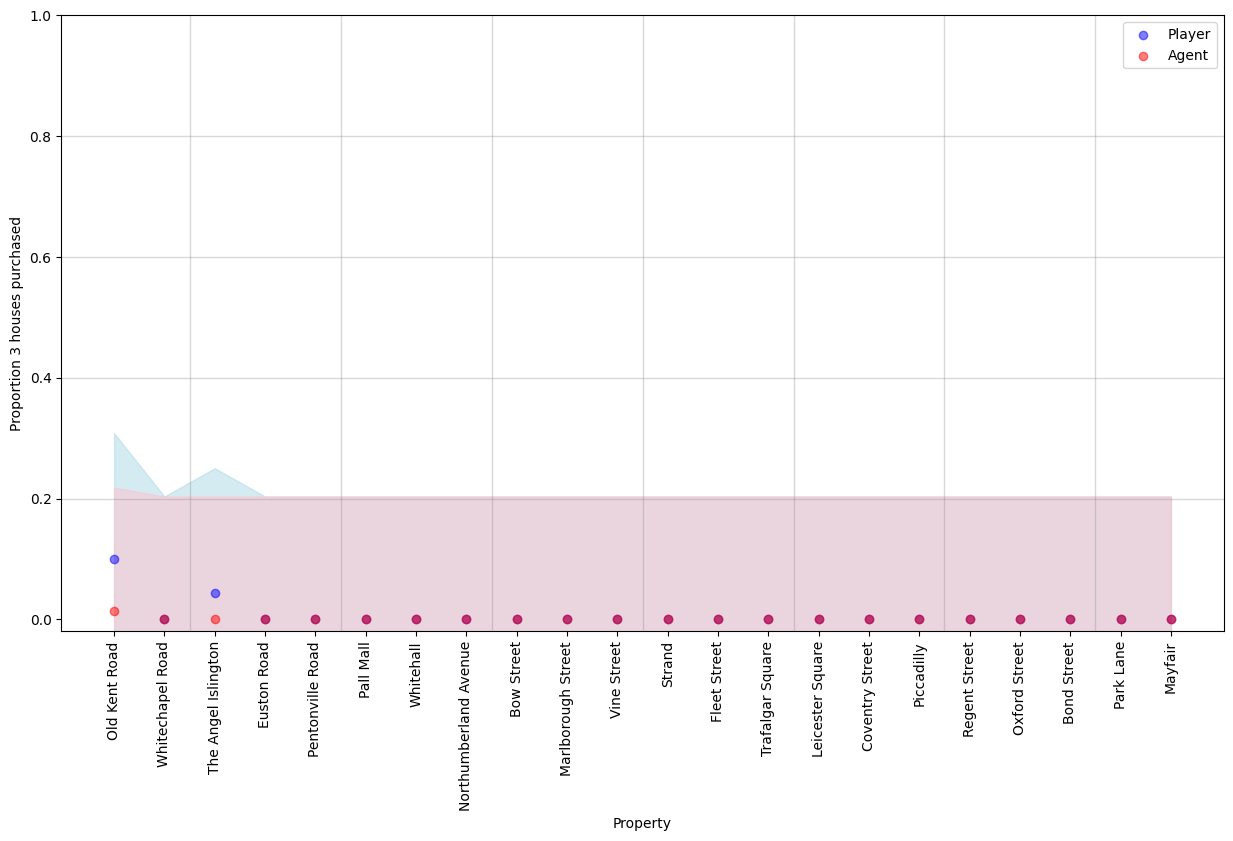

In [276]:
interval_property_plot(houses_bought_agent_3_normalised, houses_bought_player_3_normalised, 'Proportion 3 houses purchased', -0.02, 1)

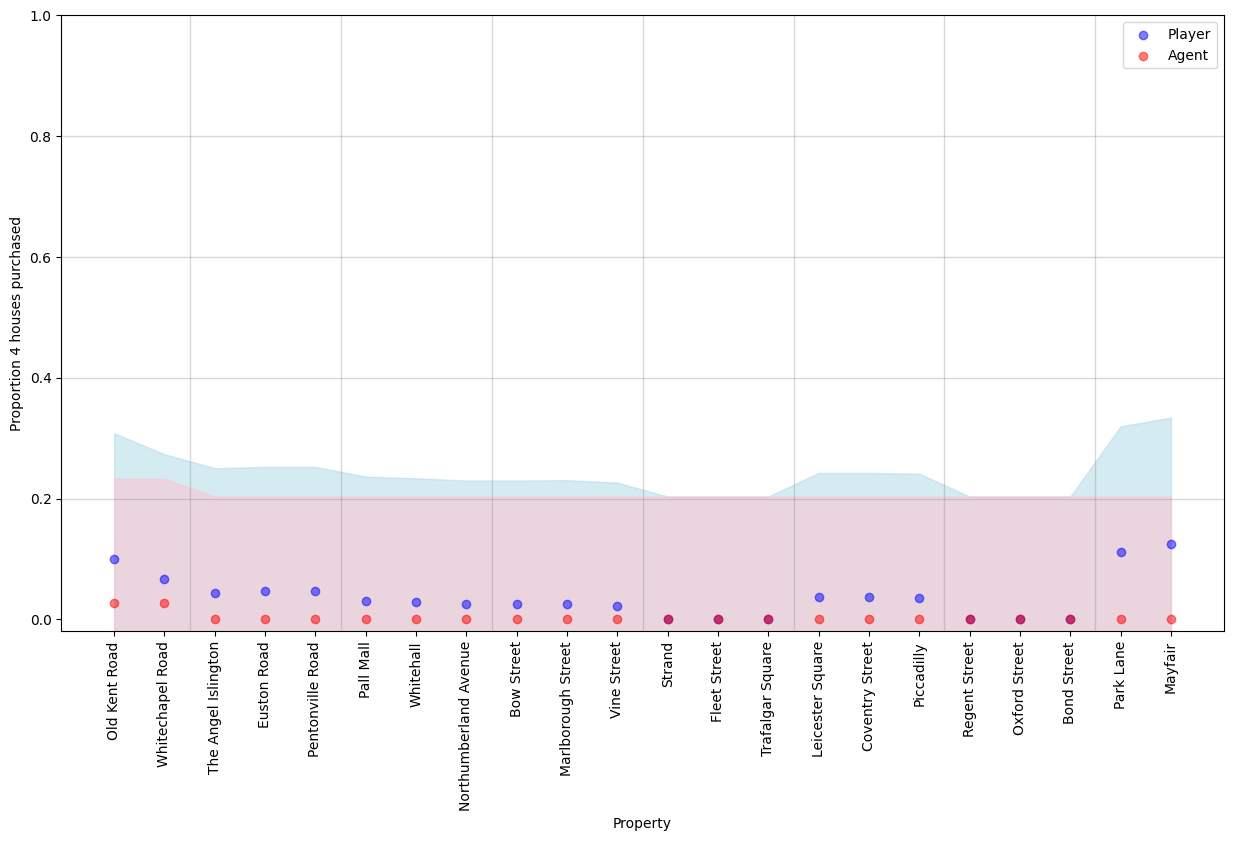

In [277]:
interval_property_plot(houses_bought_agent_4_normalised, houses_bought_player_4_normalised, 'Proportion 4 houses purchased', -0.02, 1)

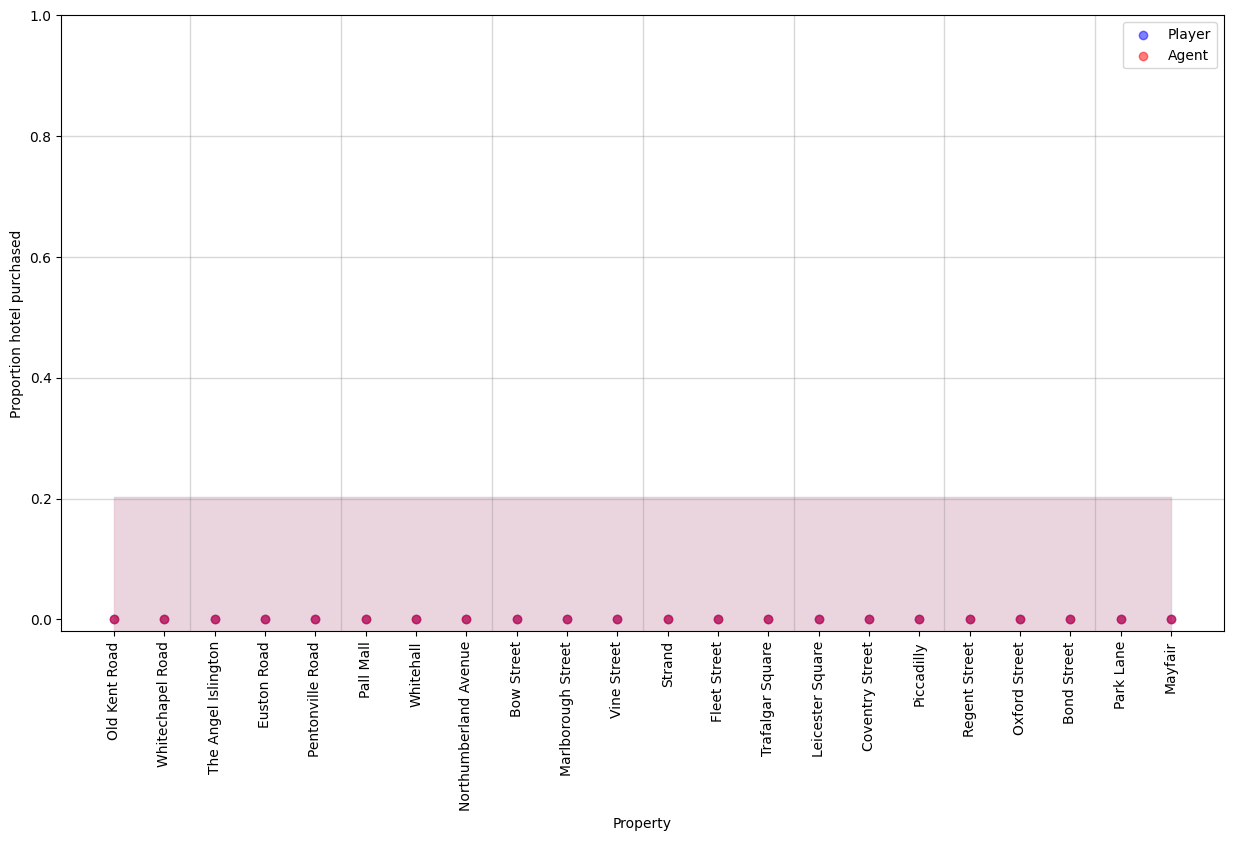

In [278]:
interval_property_plot(hotels_bought_agent_normalised, hotels_bought_player_normalised, 'Proportion hotel purchased', -0.02, 1)

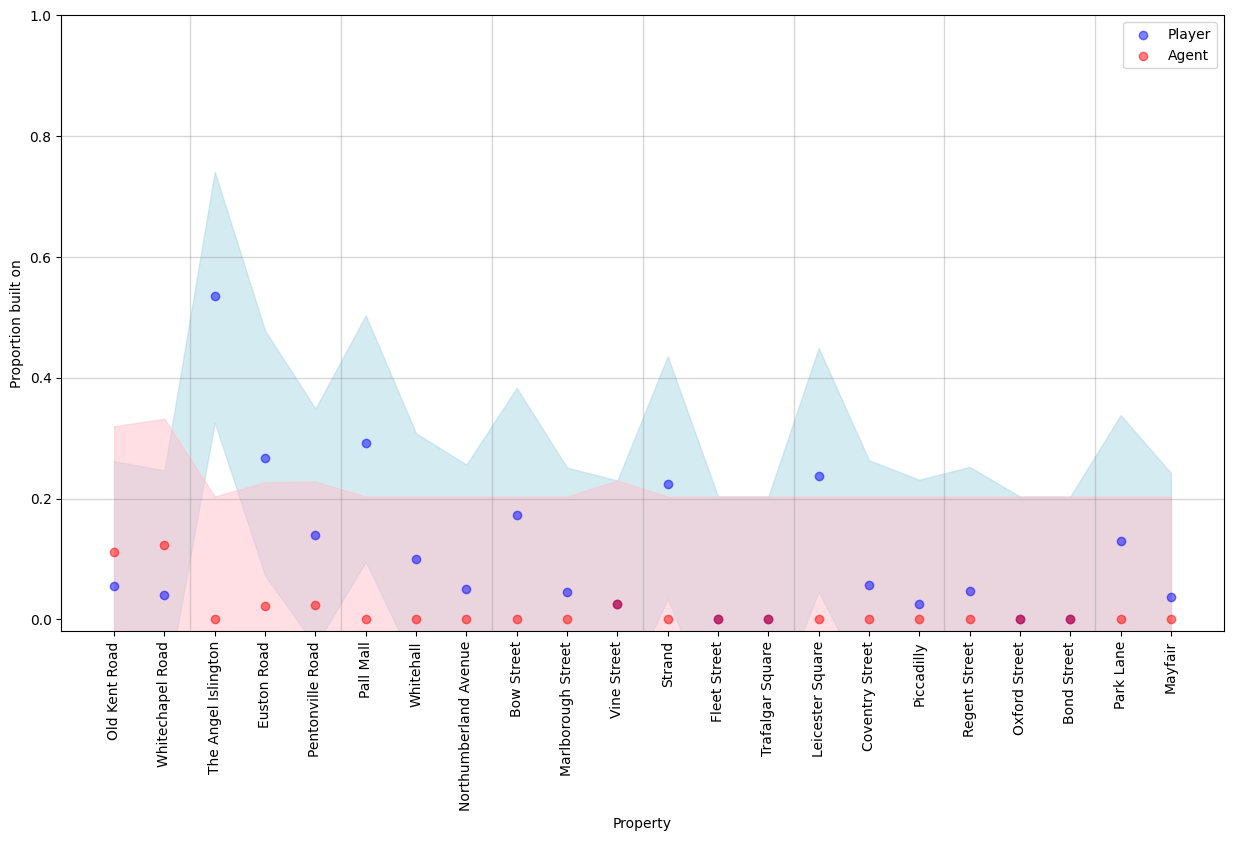

In [279]:
interval_property_plot(built_agent_normalised, built_player_normalised, 'Proportion built on', -0.02, 1)

In [280]:
mortgaged_player = [0]*28
mortgaged_agent = [0]*28

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[3]:
            mortgaged_player[idx] += 0.01
        elif prop[0] == 'Agent' and prop[3]:
            mortgaged_agent[idx] += 0.01
        else:
            pass

for game in game_outcomes['Stations']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[1]:
            mortgaged_player[idx+22] += 0.01
        elif prop[0] == 'Agent' and prop[1]:
            mortgaged_agent[idx+22] += 0.01
        else:
            pass

for game in game_outcomes['Utilities']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[1]:
            mortgaged_player[idx+26] += 0.01
        elif prop[0] == 'Agent' and prop[1]:
            mortgaged_agent[idx+26] += 0.01
        else:
            pass

In [281]:
mortgaged_player_normalised = [mortgaged_player[i]/props_bought_agent[i] for i in range(28)]
mortgaged_agent_normalised = [mortgaged_agent[i]/props_bought_agent[i] for i in range(28)]

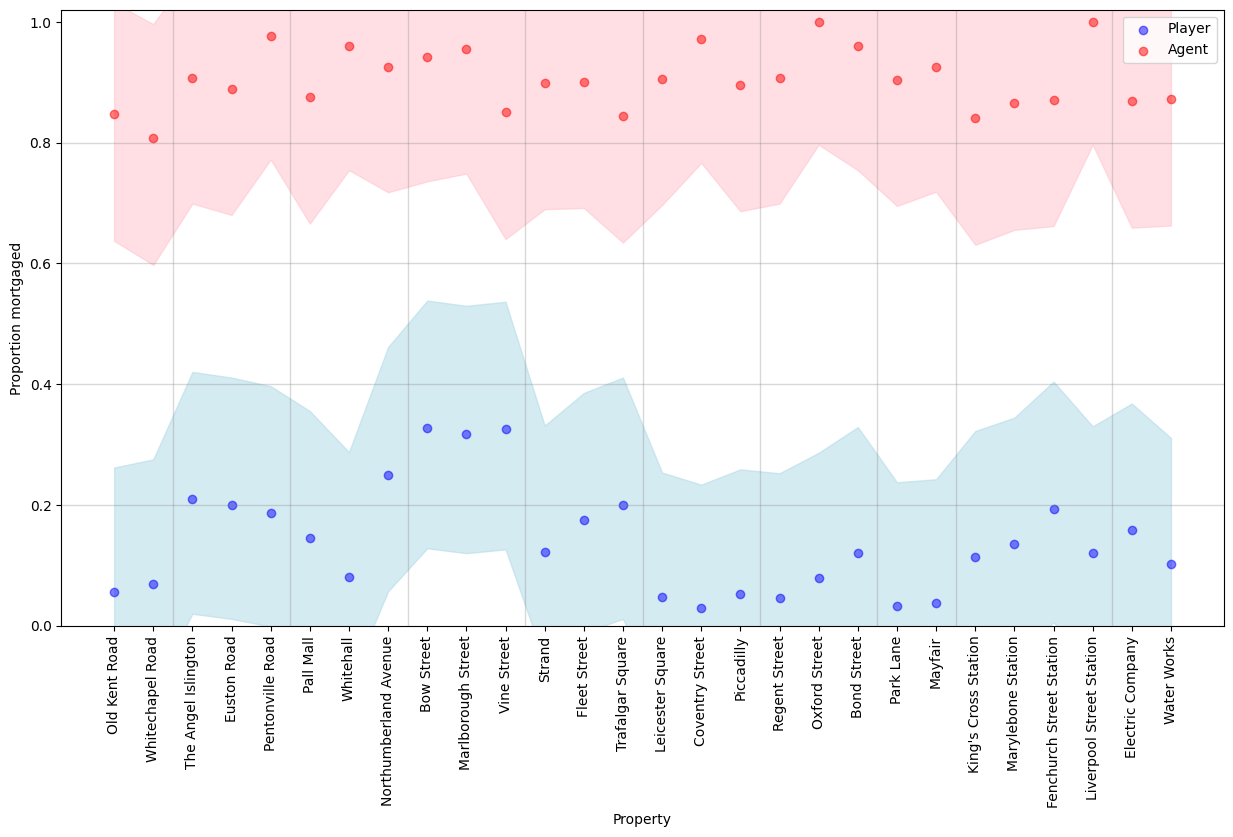

In [282]:
interval_property_plot(mortgaged_agent_normalised, mortgaged_player_normalised, 'Proportion mortgaged', 0, 1.02)

# Game Rollouts -  Base Strategy

## Rollouts

In [2]:
def game():
    node_actions = []

    # create board and add players
    board = MonopolyBoardMCTS()
    agent = Player('Agent')
    player = Player('Player')
    board.add_agent(agent)
    board.add_other_player(player)
    
    # run MCTS game
    root_state = State()
    root_state.from_monopoly_board(board)
    mcts = MCTS(root_state, max_iterations=500, exploration_weight=1, max_simulations=5)
    
    actions = 0
    max_actions = 1000
    max_rounds = 20
    pbar = tqdm(total=max_actions, desc="Running MCTS game")

    # play game until a maximum number of actions or game has ended
    while actions < max_actions and mcts.root.state.rounds < max_rounds and not mcts.root.is_terminal():
        mcts.run()
        legal_actions = [child.action for child in mcts.root.parent.children]
        node_actions.append((mcts.root.action, legal_actions, mcts.root.state.rounds, mcts.root.state.agent_wealth, mcts.root.state.other_players_wealth))
        actions += 1
        pbar.update(1)

    pbar.close()

    return mcts.root.state.rounds, mcts.root.state.agent, mcts.root.state.other_players[0], \
        mcts.root.state.properties, mcts.root.state.stations, mcts.root.state.utilities, mcts.root.state.agent_wealth, \
        mcts.root.state.other_players_wealth, node_actions

In [3]:
random.seed(42)
num_games = 5000
node_actions_5000 = []
game_outcomes = {'Rounds': [], 'Agent': [], 'Other player(s)': [], 'Properties': [], 'Stations': [], 
                 'Utilities': [], 'Agent Wealth': [], 'Other Player(s) Wealth': []}

for _ in range(num_games):
    rounds, agent, other_players, properties, stations, utilities, agent_wealth, other_players_wealth, node_actions = game()
    game_outcomes['Rounds'].append(rounds)
    game_outcomes['Agent'].append(agent)
    game_outcomes['Other player(s)'].append(other_players)
    game_outcomes['Properties'].append(properties)
    game_outcomes['Stations'].append(stations)
    game_outcomes['Utilities'].append(utilities)
    game_outcomes['Agent Wealth'].append(agent_wealth)
    game_outcomes['Other Player(s) Wealth'].append(other_players_wealth)
    node_actions_5000.append(node_actions)

Running MCTS game:   4%|▍         | 44/1000 [00:15<05:29,  2.90it/s]


In [4]:
file_path = 'MCTS_BaseStrategy_MaxRounds20_5000_game_outcomes.json'
with open(file_path, 'w') as json_file:
    json.dump(game_outcomes, json_file, indent=4)

In [17]:
file_path = 'MCTS_BaseStrategy_MaxRounds20_5000_node_actions_1.json'
with open(file_path, 'w') as json_file:
    json.dump(node_actions_5000[:2500], json_file, indent=4)

In [18]:
file_path = 'MCTS_BaseStrategy_MaxRounds20_5000_node_actions_2.json'
with open(file_path, 'w') as json_file:
    json.dump(node_actions_5000[2500:], json_file, indent=4)

## Analysing Game Outcomes

In [4]:
n = 5000

In [5]:
file_path = 'MCTS_BaseStrategy_MaxRounds20_5000_game_outcomes.json'
with open(file_path, 'r') as json_file:
    game_outcomes = json.load(json_file)

In [6]:
# game outcomes
agent_bankrupt, player_bankrupt, agent_greater_wealth, player_greater_wealth, tied = 0, 0, 0, 0, 0
for i in range(n):
    agent_wealth = game_outcomes['Agent Wealth'][i]
    player_wealth = game_outcomes['Other Player(s) Wealth'][i][0]

    if game_outcomes['Agent'][i][3]:
        agent_bankrupt += 1
    elif game_outcomes['Other player(s)'][i][3]:
        player_bankrupt += 1
    elif agent_wealth > player_wealth:
        agent_greater_wealth += 1
    elif agent_wealth < player_wealth:
        player_greater_wealth += 1
    else:
        tied += 1

print(f'Out of {n} games with 2 players, run for a maximum of 20 rounds, using a base strategy, \n\
      the agent went bankrupt in {agent_bankrupt} games, the other player went bankrupt in {player_bankrupt} games. \n\
        The agent had greater wealth in {agent_greater_wealth} games, the other player had greater wealth in \n\
            {player_greater_wealth} games. The wealth was tied in {tied} games.')

Out of 5000 games with 2 players, run for a maximum of 20 rounds, using a base strategy, 
      the agent went bankrupt in 0 games, the other player went bankrupt in 66 games. 
        The agent had greater wealth in 4637 games, the other player had greater wealth in 
            296 games. The wealth was tied in 1 games.


In [7]:
agent_bankrupt*100/n, player_bankrupt*100/n, agent_greater_wealth*100/n, player_greater_wealth*100/n, tied*100/n

(0.0, 1.32, 92.74, 5.92, 0.02)

In [8]:
mean_agent_wealth = np.mean(game_outcomes['Agent Wealth'])
mean_player_wealth = np.mean(game_outcomes['Other Player(s) Wealth'])
mean_agent_wealth, mean_player_wealth

(2417.6532, 1339.091)

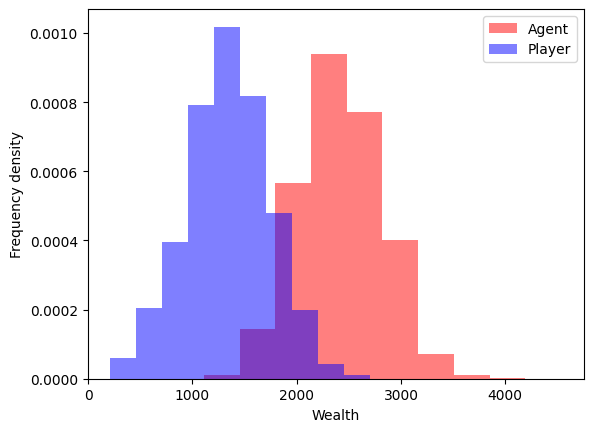

In [9]:
# wealth histogram for agent and player
plt.hist(game_outcomes['Agent Wealth'], color = 'red', alpha = 0.5, label = 'Agent', density=True)
plt.hist([i[0] for i in game_outcomes['Other Player(s) Wealth']], color = 'blue', alpha = 0.5, label = 'Player', density=True)
plt.legend()
plt.xlabel('Wealth')
plt.ylabel('Frequency density')
plt.show()

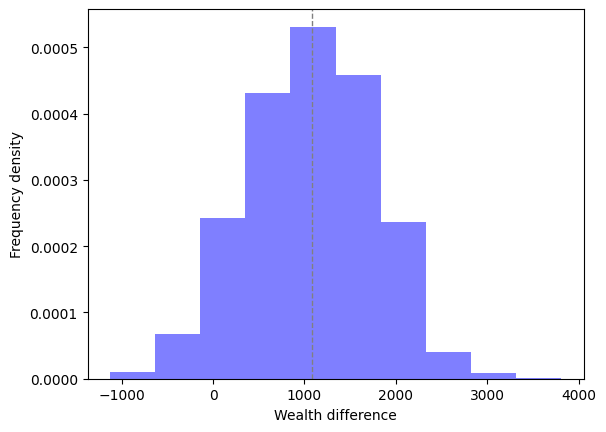

In [10]:
# distribution of differences between player and agent wealth 
wealth_diffs = [game_outcomes['Agent Wealth'][i] - game_outcomes['Other Player(s) Wealth'][i][0] for i in range(n)]
plt.hist(wealth_diffs, color = 'blue', alpha = 0.5, density=True)
plt.axvline(np.mean(wealth_diffs), color = 'grey', linestyle = 'dashed', linewidth = 1)
plt.xlabel('Wealth difference')
plt.ylabel('Frequency density')
plt.show()

In [11]:
np.mean(wealth_diffs), np.std(wealth_diffs), sum([wealth_diffs[i] < 0 for i in range(n)]), sum([wealth_diffs[i] < 0 for i in range(n)])*100/5000

(1078.5622, 688.056472196258, 296, 5.92)

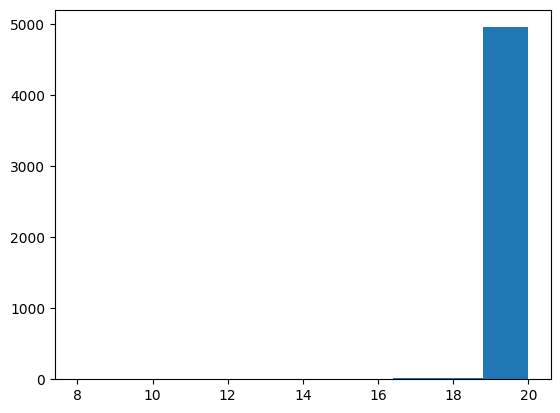

In [12]:
plt.hist(game_outcomes['Rounds'])
plt.show()

In [13]:
agent_losses = sum([agent[3] for agent in game_outcomes['Agent']])
agent_wins = sum([agent[3] for agent in game_outcomes['Other player(s)']])
agent_ahead = sum([game_outcomes['Agent Wealth'][i] > game_outcomes['Other Player(s) Wealth'][i][0] for i in range(n)]) - agent_wins
agent_behind = sum([game_outcomes['Agent Wealth'][i] < game_outcomes['Other Player(s) Wealth'][i][0] for i in range(n)]) - agent_losses
tied = n - agent_ahead - agent_behind - agent_wins - agent_losses
game_not_ended = n - agent_losses - agent_wins

print(f'Out of {n} games with 2 players, run for a maximum of 20 rounds, using a base strategy for other players,\n\
       the agent won {agent_wins} games, the other player won {agent_losses} games.\n \
       In the remaining {n-agent_wins-agent_losses} games, the agent was leading in {agent_ahead} games, and trailing in {agent_behind} games.\n\
       Overall, the agent was winning in {(agent_wins + agent_ahead)*100/n}% games.')

Out of 5000 games with 2 players, run for a maximum of 20 rounds, using a base strategy for other players,
       the agent won 66 games, the other player won 0 games.
        In the remaining 4934 games, the agent was leading in 4637 games, and trailing in 296 games.
       Overall, the agent was winning in 94.06% games.


In [14]:
street_data = [
            ("Old Kent Road", 60, 50, 2, 10, 30, 90, 160, 250, 1, "brown", 2),
            ("Whitechapel Road", 60, 50, 4, 20, 60, 180, 320, 450, 3, "brown", 2),
            ("The Angel Islington", 100, 50, 6, 30, 90, 270, 400, 550, 6, "lightblue", 3),
            ("Euston Road", 100, 50, 6, 30, 90, 270, 400, 550, 8, "lightblue", 3),
            ("Pentonville Road", 120, 50, 8, 40, 100, 300, 450, 600, 9, "lightblue", 3),
            ("Pall Mall", 140, 100, 10, 50, 150, 450, 625, 750, 11, "pink", 3),
            ("Whitehall", 140, 100, 10, 50, 150, 450, 625, 750, 13, "pink", 3),
            ("Northumberland Avenue", 160, 100, 12, 60, 180, 500, 700, 900, 14, "pink", 3),
            ("Bow Street", 180, 100, 14, 70, 200, 550, 750, 950, 16, "orange", 3),
            ("Marlborough Street", 180, 100, 14, 70, 200, 550, 750, 950, 18, "orange", 3),
            ("Vine Street", 200, 100, 16, 80, 220, 600, 800, 1000, 19, "orange", 3),
            ("The Strand", 220, 150, 18, 90, 250, 700, 875, 1050, 21, "red", 3),
            ("Fleet Street", 220, 150, 18, 90, 250, 700, 875, 1050, 23, "red", 3),
            ("Trafalgar Square", 240, 150, 20, 100, 300, 750, 925, 1100, 24, "red", 3),
            ("Leicester Square", 260, 150, 22, 110, 330, 800, 975, 1150, 26, "yellow", 3),
            ("Coventry Street", 260, 150, 22, 110, 330, 800, 975, 1150, 27, "yellow", 3),
            ("Piccadilly", 280, 150, 24, 120, 360, 850, 1025, 1200, 29, "yellow", 3),
            ("Regent Street", 300, 200, 26, 130, 390, 900, 1100, 1275, 31, "green", 3),
            ("Oxford Street", 300, 200, 26, 130, 390, 900, 1100, 1275, 32, "green", 3),
            ("Bond Street", 320, 200, 28, 150, 450, 1000, 1200, 1400, 34, "green", 3),
            ("Park Lane", 350, 200, 35, 175, 500, 1100, 1300, 1500, 37, "darkblue", 2),
            ("Mayfair", 400, 200, 50, 200, 600, 1400, 1700, 2000, 39, "darkblue", 2)
        ]

In [15]:
# wealth: money, properties (mortgaged/unmortgaged + buildings)
# agent_wealth = []
# player_wealth = []

# for idx in range(100):
#     money_agent = game_outcomes['Agent'][idx][2]
#     money_player = game_outcomes['Other player(s)'][idx][2]

#     for idx, prop in enumerate(game_outcomes['Properties'][idx]):
#         if prop[0] == 'Agent':
#             if prop[3]:
#                 money_agent += street_data[idx][1]/2
#             else:
#                 money_agent += street_data[idx][1]

#             money_agent += street_data[idx][2] * (prop[1]+prop[2])

#         elif prop[0] == 'Player':
#             if prop[3]:
#                 money_player += street_data[idx][1]/2
#             else:
#                 money_player += street_data[idx][1]

#             money_player += street_data[idx][2] * (prop[1]+prop[2])

#     agent_wealth.append(money_agent)
#     player_wealth.append(money_player)

# sum([agent_wealth[i] > player_wealth[i] for i in range(100)])

In [16]:
property_names = [
    "Old Kent Road",
    "Whitechapel Road",
    "The Angel Islington",
    "Euston Road",
    "Pentonville Road",
    "Pall Mall",
    "Whitehall",
    "Northumberland Avenue",
    "Bow Street",
    "Marlborough Street",
    "Vine Street",
    "Strand",
    "Fleet Street",
    "Trafalgar Square",
    "Leicester Square",
    "Coventry Street",
    "Piccadilly",
    "Regent Street",
    "Oxford Street",
    "Bond Street",
    "Park Lane",
    "Mayfair",
    "King's Cross Station",
    "Marylebone Station",
    "Fenchurch Street Station",
    "Liverpool Street Station",
    "Electric Company",
    "Water Works"
]

In [17]:
props_bought_player = [0]*28
props_bought_agent = [0]*28
p = 1/n

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx] += p
        elif prop[0] == 'Agent':
            props_bought_agent[idx] += p
        else:
            pass

for game in game_outcomes['Stations']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx+22] += p
        elif prop[0] == 'Agent':
            props_bought_agent[idx+22] += p
        else:
            pass

for game in game_outcomes['Utilities']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            props_bought_player[idx+26] += p
        elif prop[0] == 'Agent':
            props_bought_agent[idx+26] += p
        else:
            pass

In [18]:
def wilson_score_interval(p, n, z):
    z_squared = z**2
    phat = p + z_squared / (2 * n)
    margin_of_error = z * np.sqrt((p * (1 - p) / n) + z_squared / (4 * n))
    
    ci_lower = (phat - margin_of_error) / (1 + z_squared / n)
    ci_upper = (phat + margin_of_error) / (1 + z_squared / n)
    
    return ci_lower, ci_upper

In [19]:
def interval_property_plot(agent, player, ylabel, n=1000, ylim0=0, ylim1=1):
    num_points = len(agent)
    ci_lower_props_bought_player = [0]*num_points
    ci_lower_props_bought_agent = [0]*num_points
    ci_upper_props_bought_player = [0]*num_points
    ci_upper_props_bought_agent = [0]*num_points

    z = norm.ppf(0.975)

    for idx, p in enumerate(player):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_player[idx] = ci_lower
        ci_upper_props_bought_player[idx] = ci_upper

    for idx, p in enumerate(agent):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_agent[idx] = ci_lower
        ci_upper_props_bought_agent[idx] = ci_upper

    x = range(num_points)
    plt.figure(figsize=(15, 8))

    vertical_lines = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5]
    for i in range(len(vertical_lines)):
        plt.axvline(vertical_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    if num_points > 22:
        vertical_lines = [21.5, 25.5]
        for i in range(len(vertical_lines)):
            plt.axvline(vertical_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    horizontal_lines = [0.2, 0.4, 0.6, 0.8]
    for i in range(len(horizontal_lines)):
        plt.axhline(horizontal_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    plt.fill_between(x, ci_lower_props_bought_player, ci_upper_props_bought_player, color='lightblue', alpha=0.5)
    plt.fill_between(x, ci_lower_props_bought_agent, ci_upper_props_bought_agent, color='pink', alpha=0.5)
    plt.scatter(x, player, alpha = 0.5, color = 'blue', label = 'Player')
    plt.scatter(x, agent, alpha = 0.5, color = 'red', label = 'Agent')
        
    plt.xticks(x, property_names[:num_points], rotation = 90)
    plt.xlabel('Property')
    plt.ylabel(ylabel)
    
    plt.ylim(ylim0, ylim1)
    plt.legend()
    plt.show()

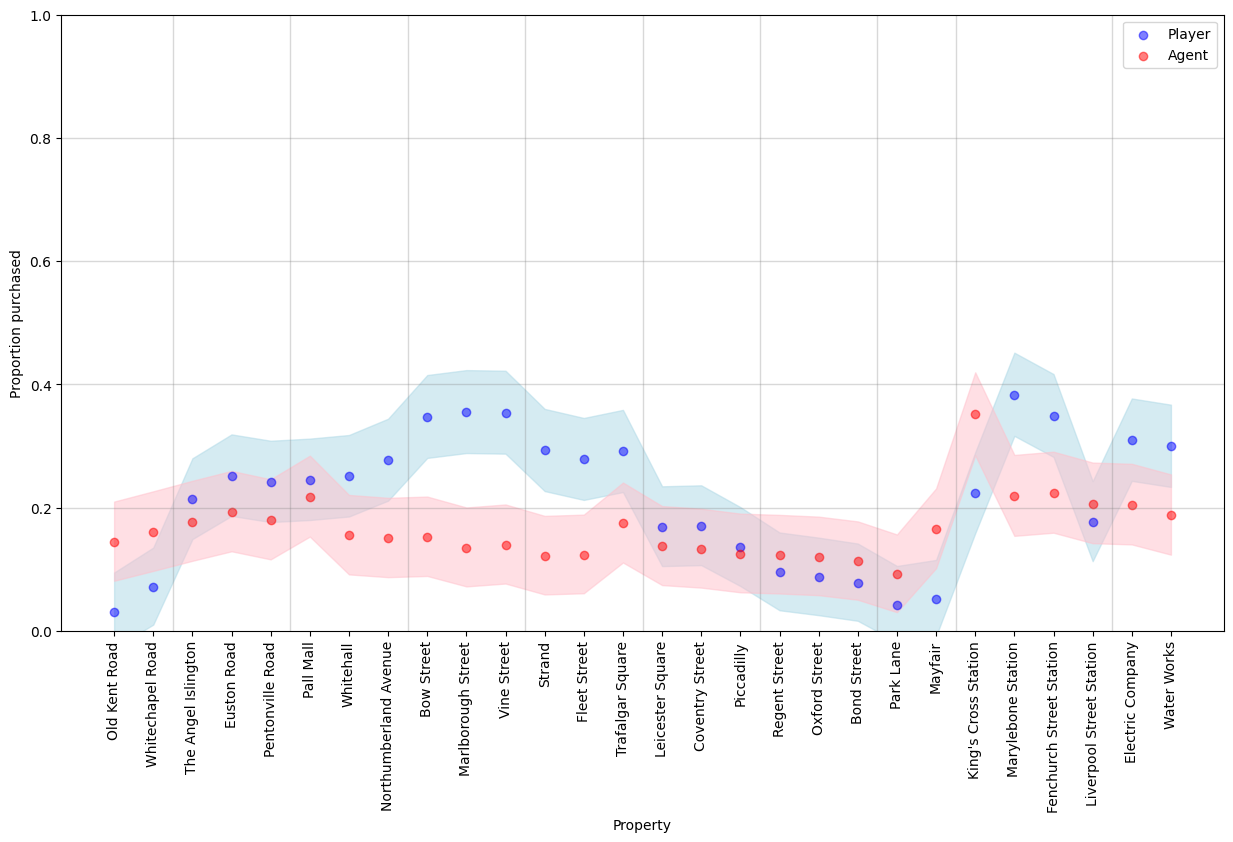

In [20]:
interval_property_plot(props_bought_agent, props_bought_player, 'Proportion purchased')

In [21]:
def interval_whiskers_property_plot(agent, player, n=1000):
    ci_lower_props_bought_player = [0]*28
    ci_lower_props_bought_agent = [0]*28
    ci_upper_props_bought_player = [0]*28
    ci_upper_props_bought_agent = [0]*28

    z = norm.ppf(0.975)

    for idx, p in enumerate(player):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_player[idx] = p - ci_lower
        ci_upper_props_bought_player[idx] = ci_upper - p

    for idx, p in enumerate(agent):
        ci_lower, ci_upper = wilson_score_interval(p, n, z)
        ci_lower_props_bought_agent[idx] = p - ci_lower
        ci_upper_props_bought_agent[idx] = ci_upper - p

    x = range(28)
    plt.figure(figsize=(15, 8))

    vertical_lines = [1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 21.5, 25.5]
    for i in range(9):
        plt.axvline(vertical_lines[i], alpha = 0.5, color = 'gray', linewidth = 1)

    horizontal_lines = [0.2, 0.4, 0.6, 0.8]
    for i in range(len(horizontal_lines)):
        plt.axhline(horizontal_lines[i], alpha = 0.3, color = 'gray', linewidth = 1)

    plt.errorbar(x, props_bought_player, yerr=[ci_lower_props_bought_player, ci_upper_props_bought_player], alpha = 0.5, fmt='o', color='blue', capsize=5, label='Player')
    plt.errorbar(x, props_bought_agent, yerr=[ci_lower_props_bought_agent, ci_upper_props_bought_agent], alpha = 0.5, fmt='o', color='red', capsize=5, label='Agent')
        
    plt.xticks(x, property_names, rotation = 90)
    plt.ylim(0, 1)
    plt.xlabel('Property')
    plt.ylabel('Proportion Purchased')
    plt.gca().xaxis.grid(False)
    plt.legend()
    plt.show()

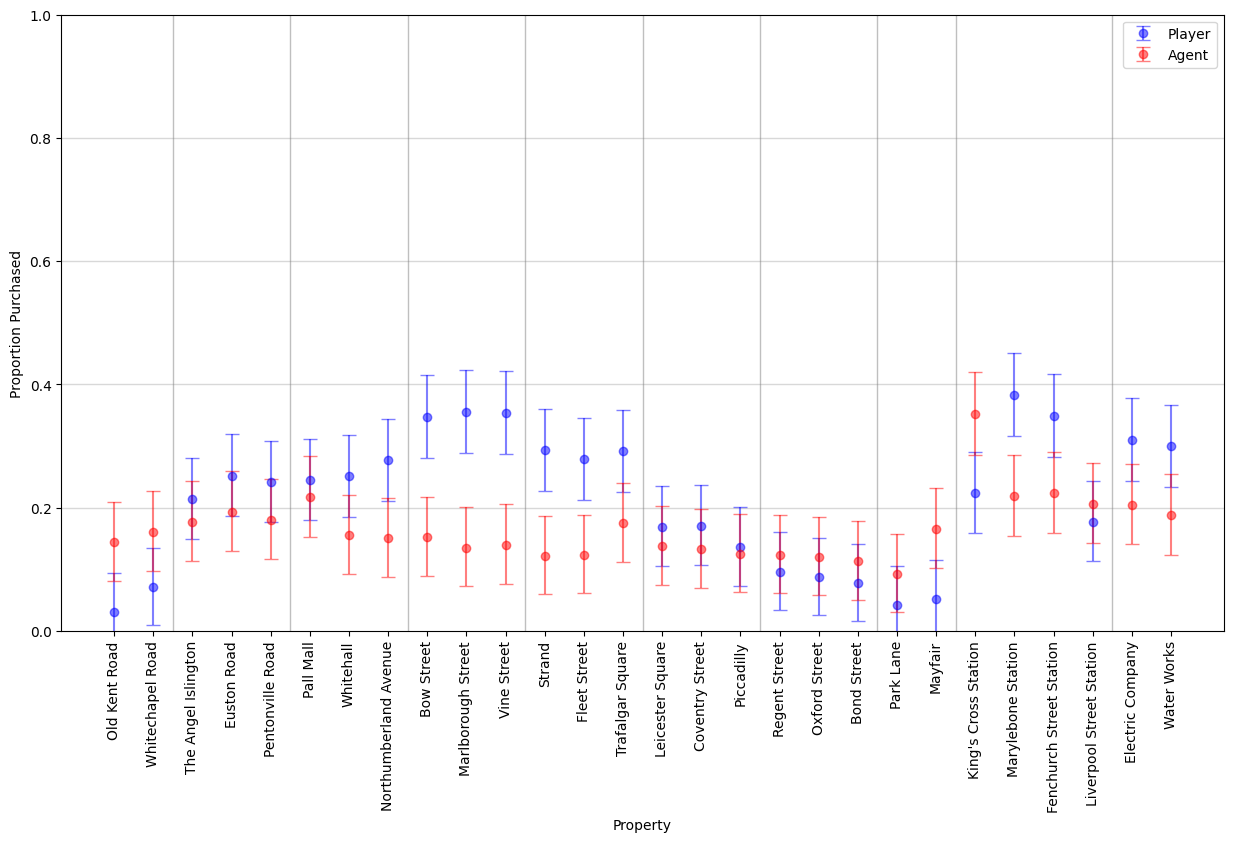

In [22]:
interval_whiskers_property_plot(props_bought_agent, props_bought_player)

In [43]:
# theta = np.linspace(0, 2 * np.pi, len(props_bought_player), endpoint=False)

# plt.figure(figsize=(8, 8))
# plt.subplot(111, polar=True)

# plt.plot(theta, props_bought_player, 'o-', color='blue', label='Player')
# plt.plot(theta, props_bought_agent, 'o-', color='red', label='Agent')
# plt.fill(theta, props_bought_player, color='blue', alpha=0.25)
# plt.fill(theta, props_bought_agent, color='red', alpha=0.25)
# plt.thetagrids(np.arange(0, 360, 360 / len(property_names)), labels=property_names)
# plt.legend()
# plt.show()

In [45]:
# bar_colours = ['brown', 'brown', 'lightblue', 'lightblue', 'lightblue', 'pink', 'pink', 'pink',
#                'orange', 'orange', 'orange', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 
#                'green', 'green', 'green', 'darkblue', 'darkblue', 'black', 'black', 'black',
#                'black', 'grey', 'grey']

# theta = np.linspace(0, 2 * np.pi, len(props_bought_agent), endpoint=False)

# plt.figure(figsize=(8, 8))
# plt.subplot(111, polar=True)

# width = 2 * np.pi / len(props_bought_agent)

# for i in range(len(props_bought_agent)):
#     plt.bar(theta[i], props_bought_agent[i], width=width, color=bar_colours[i])

# plt.thetagrids(np.arange(0, 360, 360 / len(property_names)), labels=property_names)
# plt.show()

In [23]:
num_props_bought_agent = [0] * n
num_props_bought_player = [0] * n

for idx, game in enumerate(game_outcomes['Properties']):
    for prop in game:
        if prop[0] == 'Agent':
            num_props_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_props_bought_player[idx] += 1
        else:
            pass

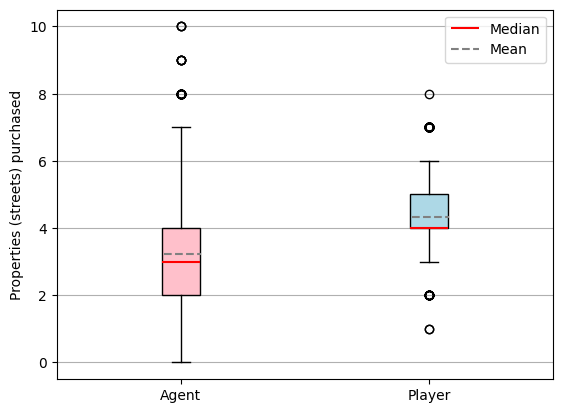

In [24]:
fig, ax = plt.subplots()
box = ax.boxplot([num_props_bought_agent, num_props_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=1.5, label='Median')
box['medians'][1].set(color='red', linewidth=1.5)

ax.set_xticks([1, 2])
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_props_bought_agent), np.mean(num_props_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_props_bought_player), np.mean(num_props_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Properties (streets) purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [25]:
num_stations_bought_agent = [0] * n
num_stations_bought_player = [0] * n

for idx, game in enumerate(game_outcomes['Stations']):
    for prop in game:
        if prop[0] == 'Agent':
            num_stations_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_stations_bought_player[idx] += 1
        else:
            pass

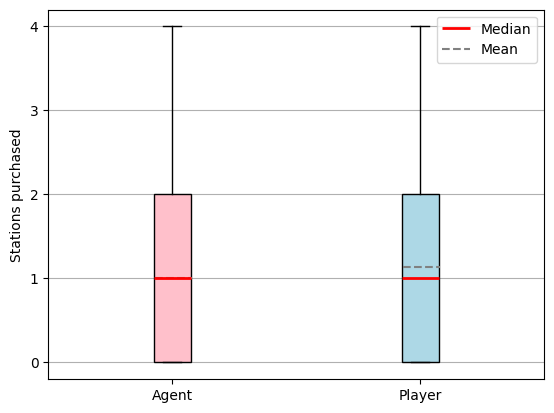

In [26]:
fig, ax = plt.subplots()
box = ax.boxplot([num_stations_bought_agent, num_stations_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=2, label='Median')
box['medians'][1].set(color='red', linewidth=2)

ax.set_xticks([1, 2])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_stations_bought_agent), np.mean(num_stations_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_stations_bought_player), np.mean(num_stations_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Stations purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [27]:
num_utilities_bought_agent = [0] * n
num_utilities_bought_player = [0] * n

for idx, game in enumerate(game_outcomes['Utilities']):
    for prop in game:
        if prop[0] == 'Agent':
            num_utilities_bought_agent[idx] += 1
        elif prop[0] == 'Player':
            num_utilities_bought_player[idx] += 1
        else:
            pass

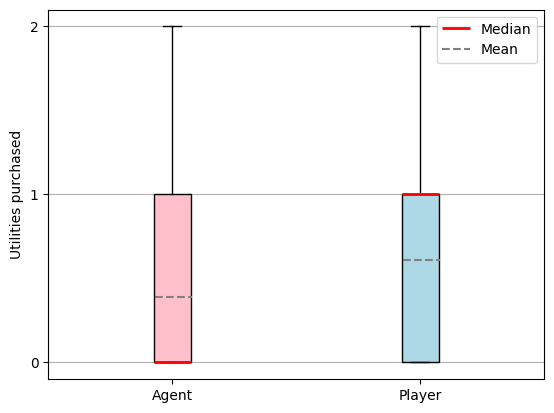

In [28]:
fig, ax = plt.subplots()
box = ax.boxplot([num_utilities_bought_agent, num_utilities_bought_player], patch_artist=True)

colors = ['pink', 'lightblue']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

box['medians'][0].set(color='red', linewidth=2, label='Median')
box['medians'][1].set(color='red', linewidth=2)

ax.set_xticks([1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Agent', 'Player']) 
plt.plot([0.93, 1.08], [np.mean(num_utilities_bought_agent), np.mean(num_utilities_bought_agent)], color='grey', linestyle='dashed', label='Mean')
plt.plot([1.93, 2.08], [np.mean(num_utilities_bought_player), np.mean(num_utilities_bought_player)], color='grey', linestyle='dashed')
plt.ylabel('Utilities purchased')
plt.grid(axis='y')
plt.legend()
plt.show()

In [29]:
houses_bought_player_1 = [0]*22
houses_bought_agent_1 = [0]*22
houses_bought_player_2 = [0]*22
houses_bought_agent_2 = [0]*22
houses_bought_player_3 = [0]*22
houses_bought_agent_3 = [0]*22
houses_bought_player_4 = [0]*22
houses_bought_agent_4 = [0]*22
hotels_bought_player = [0]*22
hotels_bought_agent = [0]*22
built_player = [0]*22
built_agent = [0]*22
p = 1/n

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player':
            if prop[1] > 0 or prop[2]:
                built_player[idx] += p

            if prop[1] == 1:
                houses_bought_player_1[idx] += p
            elif prop[1] == 2:
                houses_bought_player_2[idx] += p
            elif prop[1] == 3:
                houses_bought_player_3[idx] += p
            elif prop[1] == 4:
                houses_bought_player_4[idx] += p
            elif prop[2]:
                hotels_bought_player[idx] += p
            else:
                pass
        elif prop[0] == 'Agent':
            if prop[1] > 0 or prop[2]:
                built_agent[idx] += p

            if prop[1] == 1:
                houses_bought_agent_1[idx] += p
            elif prop[1] == 2:
                houses_bought_agent_2[idx] += p
            elif prop[1] == 3:
                houses_bought_agent_3[idx] += p
            elif prop[1] == 4:
                houses_bought_agent_4[idx] += p
            elif prop[2]:
                hotels_bought_agent[idx] += p
            else:
                pass
        else:
            pass

In [30]:
houses_bought_player_1_normalised = [houses_bought_player_1[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_1_normalised = [houses_bought_agent_1[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_2_normalised = [houses_bought_player_2[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_2_normalised = [houses_bought_agent_2[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_3_normalised = [houses_bought_player_3[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_3_normalised = [houses_bought_agent_3[i]/props_bought_agent[i] for i in range(22)]
houses_bought_player_4_normalised = [houses_bought_player_4[i]/props_bought_player[i] for i in range(22)]
houses_bought_agent_4_normalised = [houses_bought_agent_4[i]/props_bought_agent[i] for i in range(22)]
hotels_bought_player_normalised = [hotels_bought_player[i]/props_bought_player[i] for i in range(22)]
hotels_bought_agent_normalised = [hotels_bought_agent[i]/props_bought_agent[i] for i in range(22)]
built_player_normalised = [built_player[i]/props_bought_agent[i] for i in range(22)]
built_agent_normalised = [built_agent[i]/props_bought_agent[i] for i in range(22)]

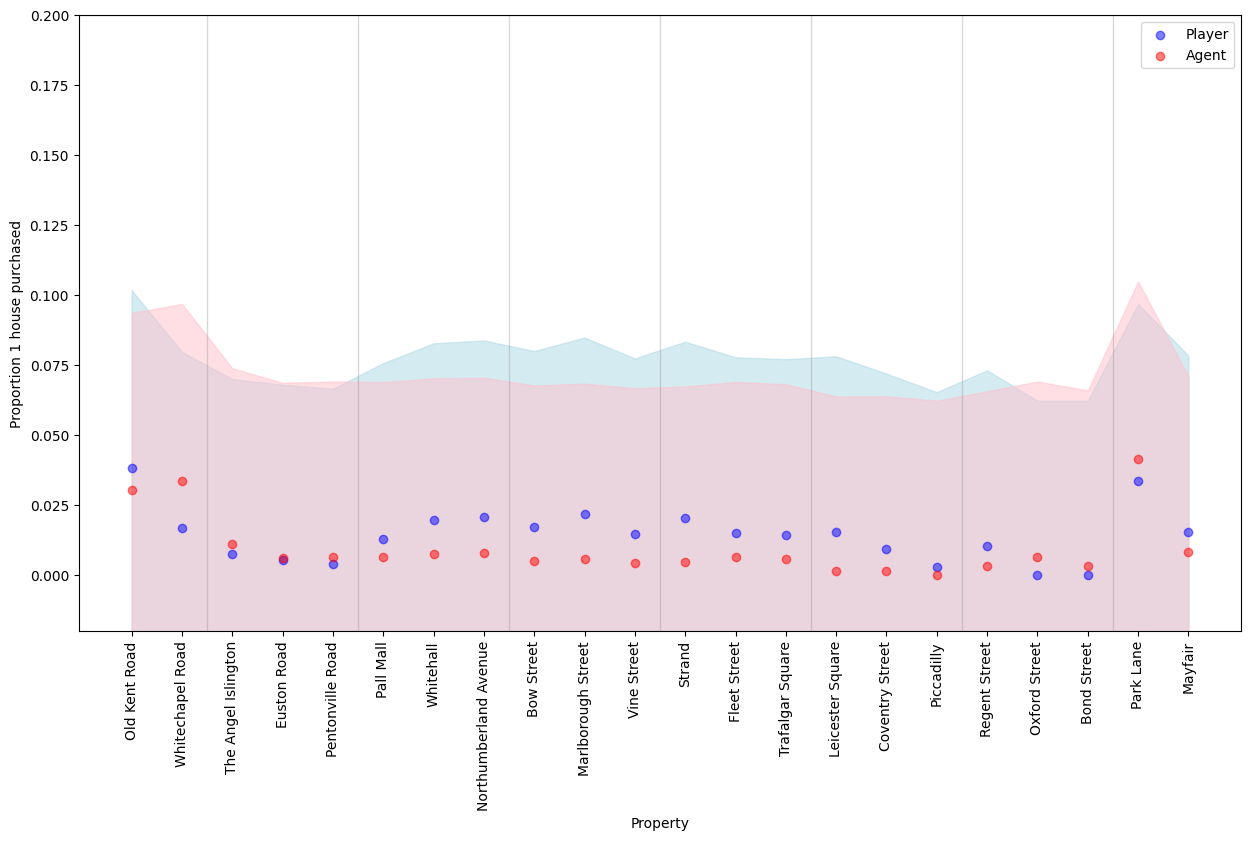

In [31]:
interval_property_plot(houses_bought_agent_1_normalised, houses_bought_player_1_normalised, 'Proportion 1 house purchased', ylim0=-0.02, ylim1=0.2)

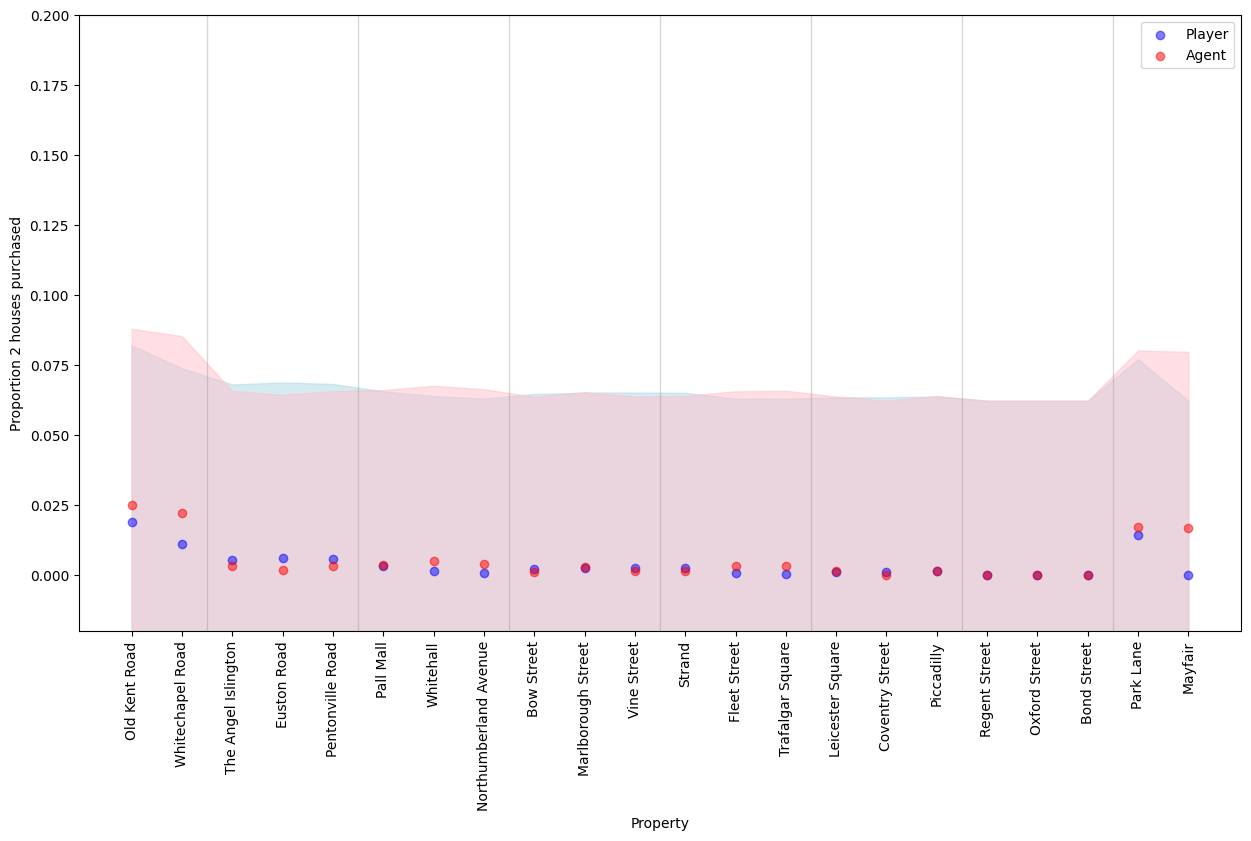

In [32]:
interval_property_plot(houses_bought_agent_2_normalised, houses_bought_player_2_normalised, 'Proportion 2 houses purchased', ylim0=-0.02, ylim1=0.2)

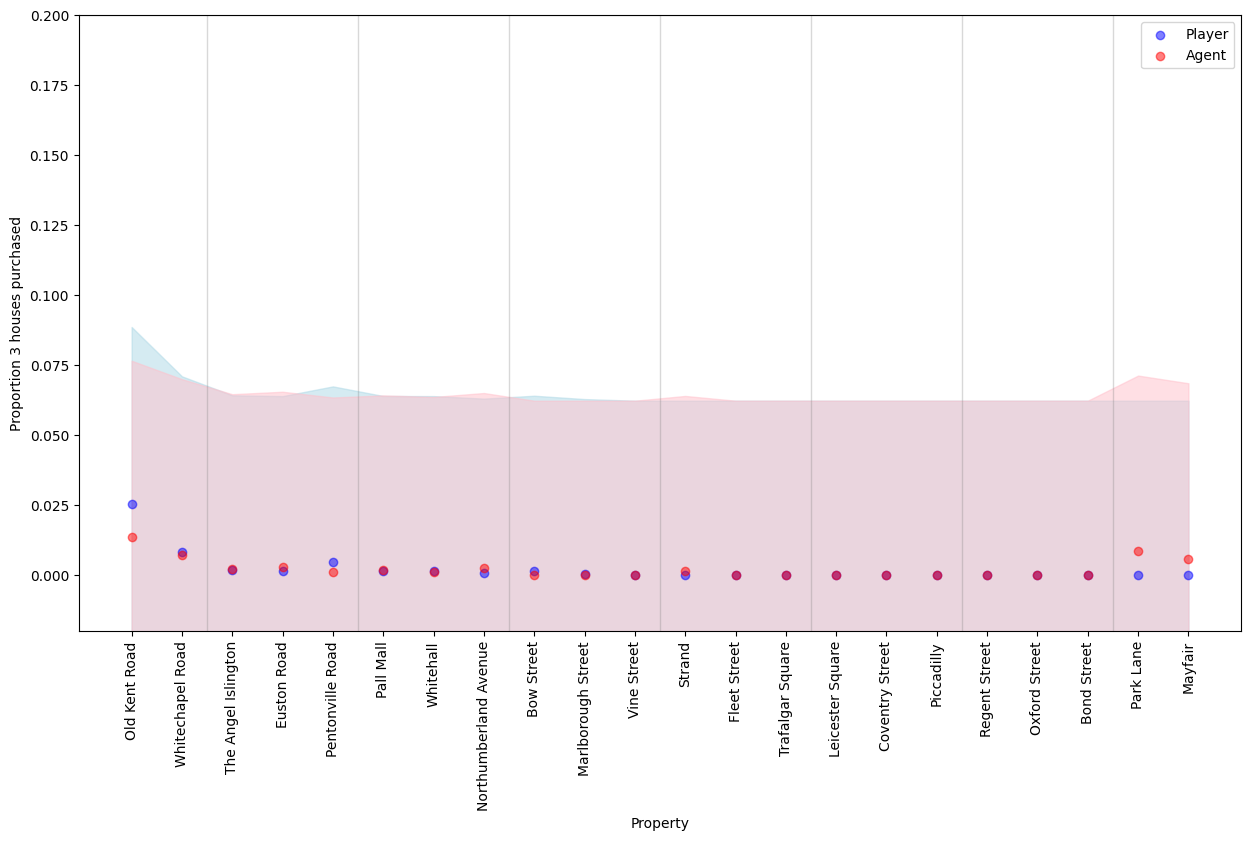

In [33]:
interval_property_plot(houses_bought_agent_3_normalised, houses_bought_player_3_normalised, 'Proportion 3 houses purchased', ylim0=-0.02, ylim1=0.2)

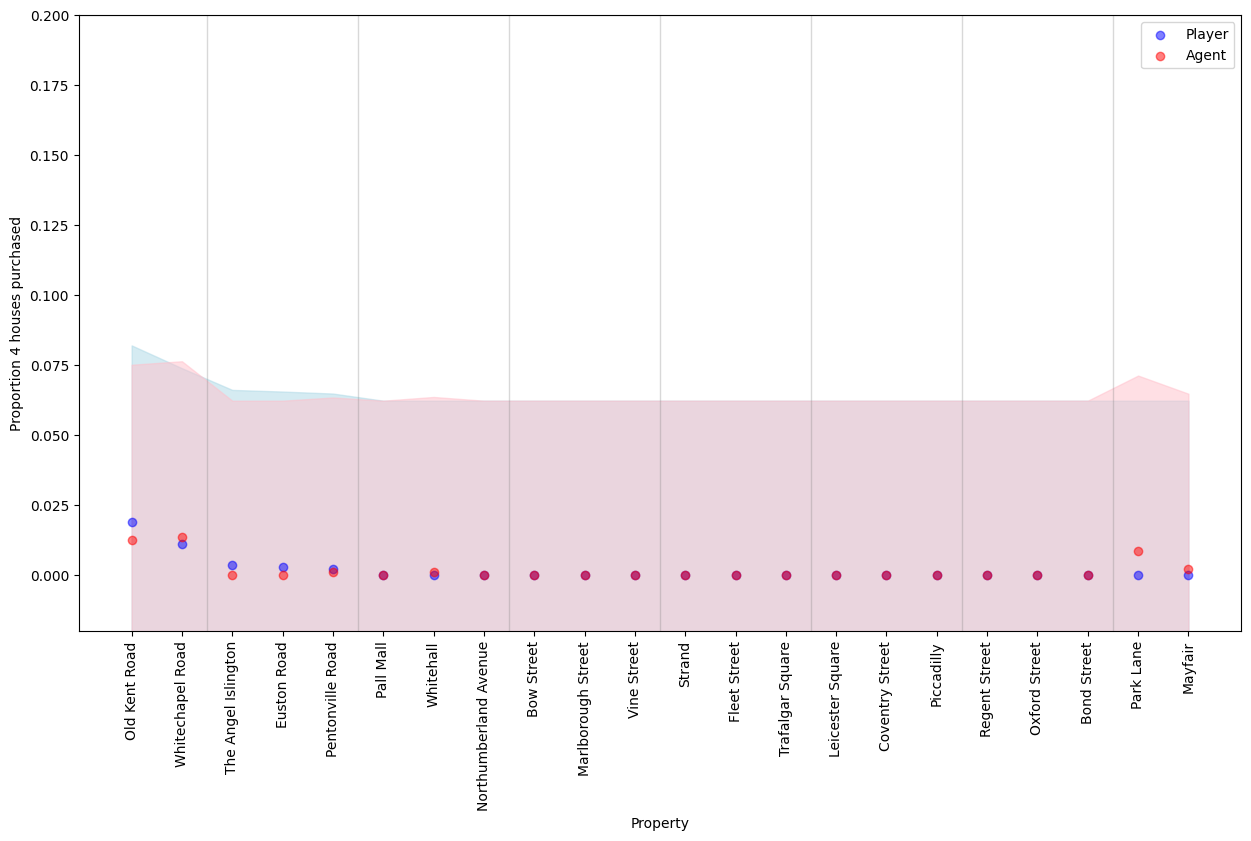

In [34]:
interval_property_plot(houses_bought_agent_4_normalised, houses_bought_player_4_normalised, 'Proportion 4 houses purchased', ylim0=-0.02, ylim1=0.2)

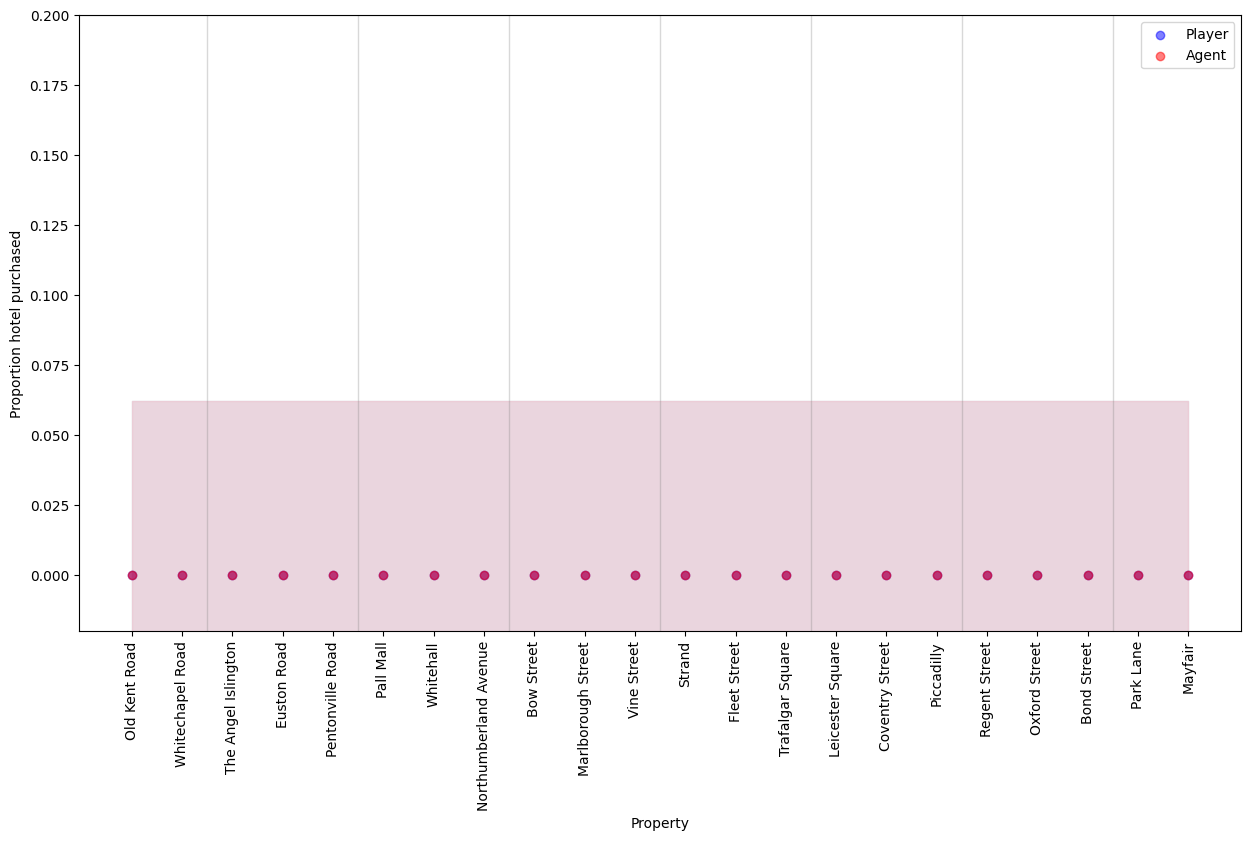

In [35]:
interval_property_plot(hotels_bought_agent_normalised, hotels_bought_player_normalised, 'Proportion hotel purchased', ylim0=-0.02, ylim1=0.2)

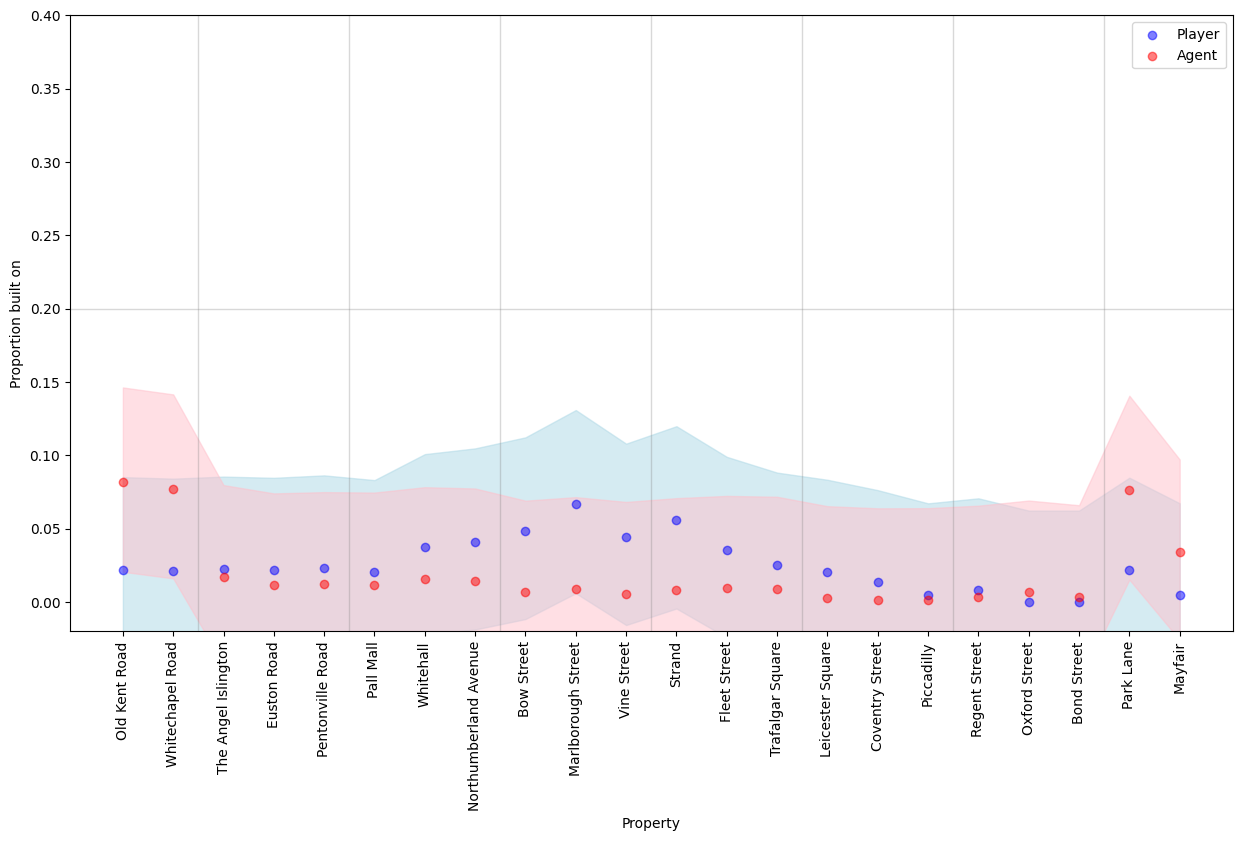

In [36]:
interval_property_plot(built_agent_normalised, built_player_normalised, 'Proportion built on', ylim0=-0.02, ylim1=0.4)

In [37]:
mortgaged_player = [0]*28
mortgaged_agent = [0]*28
p = 1/n

for game in game_outcomes['Properties']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[3]:
            mortgaged_player[idx] += p
        elif prop[0] == 'Agent' and prop[3]:
            mortgaged_agent[idx] += p
        else:
            pass

for game in game_outcomes['Stations']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[1]:
            mortgaged_player[idx+22] += p
        elif prop[0] == 'Agent' and prop[1]:
            mortgaged_agent[idx+22] += p
        else:
            pass

for game in game_outcomes['Utilities']:
    for idx, prop in enumerate(game):
        if prop[0] == 'Player' and prop[1]:
            mortgaged_player[idx+26] += p
        elif prop[0] == 'Agent' and prop[1]:
            mortgaged_agent[idx+26] += p
        else:
            pass

In [45]:
mortgaged_player_normalised = [mortgaged_player[i]/props_bought_agent[i] for i in range(28)]
mortgaged_agent_normalised = [mortgaged_agent[i]/props_bought_agent[i] for i in range(28)]

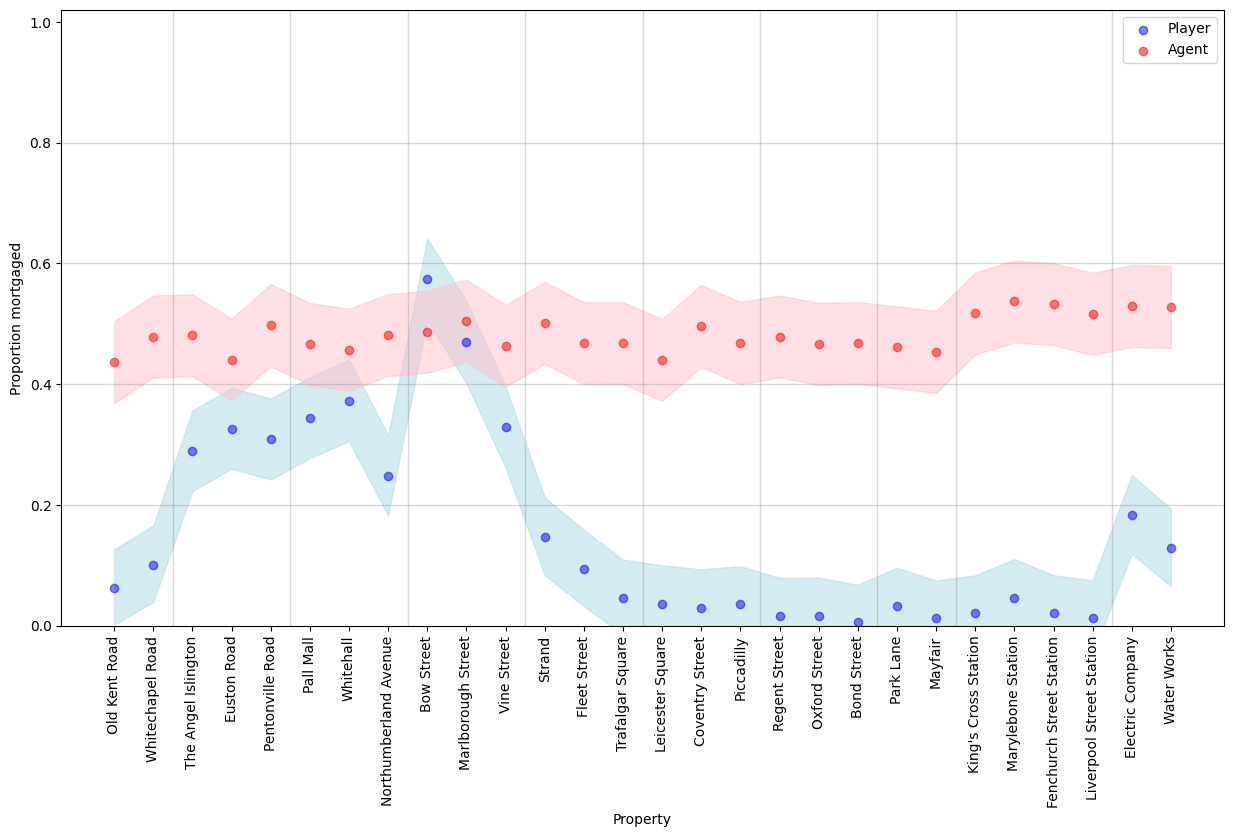

In [46]:
interval_property_plot(mortgaged_agent_normalised, mortgaged_player_normalised, 'Proportion mortgaged', ylim0=0, ylim1=1.02)

## Analysing Node Actions

In [19]:
file_path = 'MCTS_BaseStrategy_MaxRounds20_5000_node_actions_1.json'
with open(file_path, 'r') as json_file:
    node_actions_1 = json.load(json_file)

In [20]:
file_path = 'MCTS_BaseStrategy_MaxRounds20_5000_node_actions_2.json'
with open(file_path, 'r') as json_file:
    node_actions_2 = json.load(json_file)

In [23]:
node_actions = node_actions_1 + node_actions_2

In [24]:
rounds = []
for n in node_actions:
    rounds.append(n[-1][2])

np.mean(rounds), np.median(rounds), min(rounds), max(rounds)

(19.9664, 20.0, 8, 20)

### Purchasing Properties

#### Should you purchase property x?

In [15]:
property_names = [
    "Old Kent Road",
    "Whitechapel Road",
    "The Angel Islington",
    "Euston Road",
    "Pentonville Road",
    "Pall Mall",
    "Whitehall",
    "Northumberland Avenue",
    "Bow Street",
    "Marlborough Street",
    "Vine Street",
    "The Strand",
    "Fleet Street",
    "Trafalgar Square",
    "Leicester Square",
    "Coventry Street",
    "Piccadilly",
    "Regent Street",
    "Oxford Street",
    "Bond Street",
    "Park Lane",
    "Mayfair",
    "King's Cross Station",
    "Marylebone Station",
    "Fenchurch St. Station",
    "Liverpool St. Station",
    "Electric Company",
    "Water Works"
]

In [16]:
n = len(property_names)
df_purchase = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [51]:
# def populate_df(df, action_prefix):
#     for node_actions_game in tqdm(node_actions):
#         for action, legal_actions, round in node_actions_game:
#             purchase_actions = [legal_action for legal_action in legal_actions if legal_action.startswith(action_prefix)]

#             if round < 10:
#                 if action.startswith(action_prefix):
#                     property_name = action[len(action_prefix):].strip()
#                     df.loc[df["Property"] == property_name, "Action taken (early game)"] += 1

#                 if purchase_actions:
#                     for purchase_action in purchase_actions:
#                         property_name = purchase_action[len(action_prefix):].strip()
#                         df.loc[df["Property"] == property_name, "In legal actions (early game)"] += 1

#             else:
#                 if action.startswith(action_prefix):
#                     property_name = action[len(action_prefix):].strip()
#                     df.loc[df["Property"] == property_name, "Action taken (late game)"] += 1

#                 if purchase_actions:
#                     for purchase_action in purchase_actions:
#                         property_name = purchase_action[len(action_prefix):].strip()
#                         df.loc[df["Property"] == property_name, "In legal actions (late game)"] += 1

In [ ]:
def populate_df(df, action_prefix):
    for node_actions_game in tqdm(node_actions):
        for action, legal_actions, round in node_actions_game:
            purchase_actions = [legal_action for legal_action in legal_actions if legal_action.startswith(action_prefix)]

            if round < 10:
                if action.startswith(action_prefix):
                    property_name = action[len(action_prefix):].strip()
                    df.loc[df["Property"] == property_name, "Action taken (early game)"] += 1

                if purchase_actions:
                    for purchase_action in purchase_actions:
                        property_name = purchase_action[len(action_prefix):].strip()
                        df.loc[df["Property"] == property_name, "In legal actions (early game)"] += 1

            else:
                if action.startswith(action_prefix):
                    property_name = action[len(action_prefix):].strip()
                    df.loc[df["Property"] == property_name, "Action taken (late game)"] += 1

                if purchase_actions:
                    for purchase_action in purchase_actions:
                        property_name = purchase_action[len(action_prefix):].strip()
                        df.loc[df["Property"] == property_name, "In legal actions (late game)"] += 1

In [52]:
def wilson_score_error(p, n, z=norm.ppf(0.975)):
    z_squared = z**2
    phat = p + z_squared / (2 * n)
    margin_of_error = z * np.sqrt((p * (1 - p) / n) + z_squared / (4 * n))
    error = p - ((phat - margin_of_error) / (1 + z_squared / n))
    return error

In [53]:
populate_df(df_purchase, "Purchase")

  0%|          | 5/5000 [00:00<01:43, 48.27it/s]

100%|██████████| 5000/5000 [01:02<00:00, 80.54it/s]


In [54]:
df_purchase['Proportion purchased (early game)'] = df_purchase['Action taken (early game)']/df_purchase['In legal actions (early game)']
df_purchase['Proportion purchased (late game)'] = df_purchase['Action taken (late game)']/df_purchase['In legal actions (late game)']
df_purchase['Error (early game)'] = wilson_score_error(df_purchase['Proportion purchased (early game)'], df_purchase['In legal actions (early game)'])
df_purchase['Error (late game)'] = wilson_score_error(df_purchase['Proportion purchased (early game)'], df_purchase['In legal actions (late game)'])
df_purchase.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion purchased (early game),Proportion purchased (late game),Error (early game),Error (late game)
0,Old Kent Road,936,2586,241,479,0.257479,0.185228,0.067474,0.040938
1,Whitechapel Road,1264,2452,382,420,0.302215,0.171289,0.058882,0.042460
2,The Angel Islington,1436,1978,525,361,0.365599,0.182508,0.055967,0.047766
3,Euston Road,1596,1943,600,365,0.375940,0.187854,0.053204,0.048265
4,Pentonville Road,1502,2130,531,367,0.353529,0.172300,0.054628,0.045958


In [55]:
sorted_df = df_purchase.sort_values(by='Proportion purchased (early game)', ascending=False)
sorted_df[['Property', 'Proportion purchased (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion purchased (early game),Error (early game),In legal actions (early game),Action taken (early game)
24,Fenchurch St. Station,0.421396,0.054598,1533,646
23,Marylebone Station,0.410072,0.052293,1668,684
25,Liverpool St. Station,0.409295,0.058407,1334,546
22,King's Cross Station,0.399088,0.043481,2413,963
27,Water Works,0.394209,0.058013,1347,531
26,Electric Company,0.392483,0.052888,1623,637
3,Euston Road,0.375940,0.053204,1596,600
2,The Angel Islington,0.365599,0.055967,1436,525
4,Pentonville Road,0.353529,0.054628,1502,531
6,Whitehall,0.338776,0.060249,1225,415


In [56]:
sorted_df = df_purchase.sort_values(by='Proportion purchased (late game)', ascending=False)
sorted_df[['Property', 'Proportion purchased (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion purchased (late game),Error (late game),In legal actions (late game),Action taken (late game)
22,King's Cross Station,0.253346,0.038160,3138,795
25,Liverpool St. Station,0.244713,0.047953,1986,486
23,Marylebone Station,0.243452,0.052107,1680,409
24,Fenchurch St. Station,0.239010,0.048101,1979,473
27,Water Works,0.220054,0.049644,1845,406
26,Electric Company,0.211306,0.049943,1822,385
3,Euston Road,0.187854,0.048265,1943,365
0,Old Kent Road,0.185228,0.040938,2586,479
2,The Angel Islington,0.182508,0.047766,1978,361
6,Whitehall,0.177756,0.047132,2014,358


In [57]:
def plot_action_proportions(df, y1, y2, ylabel, max_idx=28):
    fig = px.scatter(
        df.loc[:max_idx],
        x='Property',
        y=y1,
        error_y='Error (early game)',
        opacity=0.5
    )

    fig2 = px.scatter(
        df.loc[:max_idx],
        x='Property',
        y=y2,
        error_y='Error (late game)',
        color_discrete_sequence=['red']
    )

    fig.update_traces(
        name='Early Game',  
        showlegend=True
    )

    fig2.update_traces(
        name='Late Game',  
        showlegend=True,
        opacity=0.5
    )

    fig.update_layout(
        yaxis_title=ylabel,
        yaxis=dict(range=[0, 1]),
        xaxis_tickangle=270,
        height=800
    )

    fig.add_trace(fig2.data[0])
    fig.show()

In [58]:
plot_action_proportions(df_purchase, 'Proportion purchased (early game)', 'Proportion purchased (late game)', 'Proportion purchased')

### Building on Properties

#### Should I purchase a house on property x?

In [59]:
n = len(property_names)
df_build_house = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [60]:
populate_df(df_build_house, "Buy house on")

100%|██████████| 5000/5000 [00:06<00:00, 801.77it/s] 


In [61]:
df_build_house['Proportion built house on (early game)'] = df_build_house['Action taken (early game)']/df_build_house['In legal actions (early game)']
df_build_house['Proportion built house on (late game)'] = df_build_house['Action taken (late game)']/df_build_house['In legal actions (late game)']
df_build_house['Error (early game)'] = wilson_score_error(df_build_house['Proportion built house on (early game)'], df_build_house['In legal actions (early game)'])
df_build_house['Error (late game)'] = wilson_score_error(df_build_house['Proportion built house on (early game)'], df_build_house['In legal actions (late game)'])
df_build_house.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion built house on (early game),Proportion built house on (late game),Error (early game),Error (late game)
0,Old Kent Road,138,2190,36,264,0.260870,0.120548,0.167838,0.044478
1,Whitechapel Road,129,2208,22,266,0.170543,0.120471,0.166373,0.043135
2,The Angel Islington,0,498,0,54,NaN,0.108434,NaN,NaN
3,Euston Road,0,493,0,57,NaN,0.115619,NaN,NaN
4,Pentonville Road,0,525,0,53,NaN,0.100952,NaN,NaN


In [62]:
sorted_df = df_build_house.sort_values(by='Proportion built house on (early game)', ascending=False)
sorted_df[['Property', 'Proportion built house on (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion built house on (early game),Error (early game),In legal actions (early game),Action taken (early game)
7,Northumberland Avenue,0.285714,0.440214,7,2
0,Old Kent Road,0.260870,0.167838,138,36
21,Mayfair,0.173077,0.243385,52,9
1,Whitechapel Road,0.170543,0.166373,129,22
20,Park Lane,0.169811,0.241125,53,9
5,Pall Mall,0.142857,0.371175,7,1
6,Whitehall,0.000000,0.292877,15,0
11,The Strand,0.000000,0.136198,2,0
12,Fleet Street,0.000000,0.136198,2,0
13,Trafalgar Square,0.000000,0.136198,2,0


In [63]:
sorted_df = df_build_house.sort_values(by='Proportion built house on (late game)', ascending=False)
sorted_df[['Property', 'Proportion built house on (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion built house on (late game),Error (late game),In legal actions (late game),Action taken (late game)
16,Piccadilly,0.200000,NaN,25,5
14,Leicester Square,0.200000,NaN,25,5
20,Park Lane,0.150974,0.080314,616,93
21,Mayfair,0.144144,0.077448,666,96
13,Trafalgar Square,0.125926,0.146902,135,17
11,The Strand,0.124088,0.145986,137,17
12,Fleet Street,0.122807,0.157729,114,14
0,Old Kent Road,0.120548,0.044478,2190,264
1,Whitechapel Road,0.120471,0.043135,2208,266
9,Marlborough Street,0.117647,NaN,119,14


In [64]:
plot_action_proportions(df_build_house, 'Proportion built house on (early game)', 
                        'Proportion built house on (late game)', 'Proportion built house on', 21)

#### A hotel?

In [65]:
n = len(property_names)
df_build_hotel = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [66]:
populate_df(df_build_hotel, "Buy hotel on")

100%|██████████| 5000/5000 [00:00<00:00, 12077.90it/s]


In [67]:
df_build_hotel['Proportion built hotel on (early game)'] = df_build_hotel['Action taken (early game)']/df_build_hotel['In legal actions (early game)']
df_build_hotel['Proportion built hotel on (late game)'] = df_build_hotel['Action taken (late game)']/df_build_hotel['In legal actions (late game)']
df_build_hotel['Error (early game)'] = wilson_score_error(df_build_hotel['Proportion built hotel on (early game)'], df_build_hotel['In legal actions (early game)'])
df_build_hotel['Error (late game)'] = wilson_score_error(df_build_hotel['Proportion built hotel on (early game)'], df_build_hotel['In legal actions (late game)'])
df_build_hotel.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion built hotel on (early game),Proportion built hotel on (late game),Error (early game),Error (late game)
0,Old Kent Road,0,53,0,12,NaN,0.226415,NaN,NaN
1,Whitechapel Road,0,74,0,4,NaN,0.054054,NaN,NaN
2,The Angel Islington,0,9,0,1,NaN,0.111111,NaN,NaN
3,Euston Road,0,12,0,2,NaN,0.166667,NaN,NaN
4,Pentonville Road,0,15,0,0,NaN,0.000000,NaN,NaN


In [68]:
sorted_df = df_build_hotel.sort_values(by='Proportion built hotel on (early game)', ascending=False)
sorted_df[['Property', 'Proportion built hotel on (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion built hotel on (early game),Error (early game),In legal actions (early game),Action taken (early game)
0,Old Kent Road,NaN,NaN,0,0
1,Whitechapel Road,NaN,NaN,0,0
2,The Angel Islington,NaN,NaN,0,0
3,Euston Road,NaN,NaN,0,0
4,Pentonville Road,NaN,NaN,0,0
5,Pall Mall,NaN,NaN,0,0
6,Whitehall,NaN,NaN,0,0
7,Northumberland Avenue,NaN,NaN,0,0
8,Bow Street,NaN,NaN,0,0
9,Marlborough Street,NaN,NaN,0,0


In [69]:
sorted_df = df_build_hotel.sort_values(by='Proportion built hotel on (late game)', ascending=False)
sorted_df[['Property', 'Proportion built hotel on (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion built hotel on (late game),Error (late game),In legal actions (late game),Action taken (late game)
20,Park Lane,0.285714,NaN,7,2
0,Old Kent Road,0.226415,NaN,53,12
3,Euston Road,0.166667,NaN,12,2
2,The Angel Islington,0.111111,NaN,9,1
1,Whitechapel Road,0.054054,NaN,74,4
4,Pentonville Road,0.000000,NaN,15,0
21,Mayfair,0.000000,NaN,10,0
5,Pall Mall,NaN,NaN,0,0
6,Whitehall,NaN,NaN,0,0
7,Northumberland Avenue,NaN,NaN,0,0


In [70]:
plot_action_proportions(df_build_hotel, 'Proportion built hotel on (early game)', 
                        'Proportion built hotel on (late game)', 'Proportion built hotel on', 21)

#### Should I build on property x?

In [71]:
df_build = pd.DataFrame({'Property': property_names, 
                         'In legal actions (early game)': df_build_house['In legal actions (early game)']+df_build_hotel['In legal actions (early game)'], 
                         'In legal actions (late game)': df_build_house['In legal actions (late game)']+df_build_hotel['In legal actions (late game)'],
                         'Action taken (early game)': df_build_house['Action taken (early game)']+df_build_hotel['Action taken (early game)'], 
                         'Action taken (late game)': df_build_house['Action taken (late game)']+df_build_hotel['Action taken (late game)']})

In [72]:
df_build['Proportion built on (early game)'] = df_build['Action taken (early game)']/df_build['In legal actions (early game)']
df_build['Proportion built on (late game)'] = df_build['Action taken (late game)']/df_build['In legal actions (late game)']
df_build['Error (early game)'] = wilson_score_error(df_build['Proportion built on (early game)'], df_build['In legal actions (early game)'])
df_build['Error (late game)'] = wilson_score_error(df_build['Proportion built on (early game)'], df_build['In legal actions (late game)'])
df_build.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion built on (early game),Proportion built on (late game),Error (early game),Error (late game)
0,Old Kent Road,138,2243,36,276,0.260870,0.123049,0.167838,0.043956
1,Whitechapel Road,129,2282,22,270,0.170543,0.118317,0.166373,0.042441
2,The Angel Islington,0,507,0,55,NaN,0.108481,NaN,NaN
3,Euston Road,0,505,0,59,NaN,0.116832,NaN,NaN
4,Pentonville Road,0,540,0,53,NaN,0.098148,NaN,NaN


In [73]:
sorted_df = df_build.sort_values(by='Proportion built on (early game)', ascending=False)
sorted_df[['Property', 'Proportion built on (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion built on (early game),Error (early game),In legal actions (early game),Action taken (early game)
7,Northumberland Avenue,0.285714,0.440214,7,2
0,Old Kent Road,0.260870,0.167838,138,36
21,Mayfair,0.173077,0.243385,52,9
1,Whitechapel Road,0.170543,0.166373,129,22
20,Park Lane,0.169811,0.241125,53,9
5,Pall Mall,0.142857,0.371175,7,1
6,Whitehall,0.000000,0.292877,15,0
11,The Strand,0.000000,0.136198,2,0
12,Fleet Street,0.000000,0.136198,2,0
13,Trafalgar Square,0.000000,0.136198,2,0


In [74]:
sorted_df = df_build.sort_values(by='Proportion built on (late game)', ascending=False)
sorted_df[['Property', 'Proportion built on (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion built on (late game),Error (late game),In legal actions (late game),Action taken (late game)
16,Piccadilly,0.200000,NaN,25,5
14,Leicester Square,0.200000,NaN,25,5
20,Park Lane,0.152488,0.079879,623,95
21,Mayfair,0.142012,0.076893,676,96
13,Trafalgar Square,0.125926,0.146902,135,17
11,The Strand,0.124088,0.145986,137,17
0,Old Kent Road,0.123049,0.043956,2243,276
12,Fleet Street,0.122807,0.157729,114,14
1,Whitechapel Road,0.118317,0.042441,2282,270
9,Marlborough Street,0.117647,NaN,119,14


In [75]:
plot_action_proportions(df_build, 'Proportion built on (early game)', 
                        'Proportion built on (late game)', 'Proportion built on', 21)

### Mortgaging Properties

#### Should I mortgage property x?

In [76]:
n = len(property_names)
df_mortgage = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [77]:
populate_df(df_mortgage, "Mortgage")

100%|██████████| 5000/5000 [05:16<00:00, 15.82it/s]


In [78]:
df_mortgage['Proportion mortgaged (early game)'] = df_mortgage['Action taken (early game)']/df_mortgage['In legal actions (early game)']
df_mortgage['Proportion mortgaged (late game)'] = df_mortgage['Action taken (late game)']/df_mortgage['In legal actions (late game)']
df_mortgage['Error (early game)'] = wilson_score_error(df_mortgage['Proportion mortgaged (early game)'], df_mortgage['In legal actions (early game)'])
df_mortgage['Error (late game)'] = wilson_score_error(df_mortgage['Proportion mortgaged (early game)'], df_mortgage['In legal actions (late game)'])
df_mortgage.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion mortgaged (early game),Proportion mortgaged (late game),Error (early game),Error (late game)
0,Old Kent Road,1590,12955,417,2013,0.262264,0.155384,0.052098,0.018421
1,Whitechapel Road,3314,15745,852,2510,0.257091,0.159416,0.036209,0.016697
2,The Angel Islington,4843,17982,1328,2827,0.274210,0.157213,0.030122,0.015686
3,Euston Road,5875,20073,1519,3194,0.258553,0.159119,0.027271,0.014799
4,Pentonville Road,4768,18581,1281,2906,0.268666,0.156396,0.030319,0.015414


In [79]:
sorted_df = df_mortgage.sort_values(by='Proportion mortgaged (early game)', ascending=False)
sorted_df[['Property', 'Proportion mortgaged (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion mortgaged (early game),Error (early game),In legal actions (early game),Action taken (early game)
7,Northumberland Avenue,0.283514,0.035429,3506,994
2,The Angel Islington,0.274210,0.030122,4843,1328
6,Whitehall,0.273902,0.035468,3483,954
8,Bow Street,0.271373,0.034748,3626,984
4,Pentonville Road,0.268666,0.030319,4768,1281
15,Coventry Street,0.268100,0.043689,2279,611
9,Marlborough Street,0.263111,0.036138,3337,878
0,Old Kent Road,0.262264,0.052098,1590,417
14,Leicester Square,0.261814,0.040688,2624,687
10,Vine Street,0.261374,0.036954,3187,833


In [80]:
sorted_df = df_mortgage.sort_values(by='Proportion mortgaged (late game)', ascending=False)
sorted_df[['Property', 'Proportion mortgaged (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion mortgaged (late game),Error (late game),In legal actions (late game),Action taken (late game)
27,Water Works,0.169287,0.016027,17048,2886
25,Liverpool St. Station,0.164759,0.015259,18694,3080
23,Marylebone Station,0.163668,0.015021,19454,3184
22,King's Cross Station,0.161757,0.011648,32320,5228
24,Fenchurch St. Station,0.161136,0.015082,19226,3098
15,Coventry Street,0.160174,0.018661,12655,2027
5,Pall Mall,0.159451,0.014339,21411,3414
1,Whitechapel Road,0.159416,0.016697,15745,2510
3,Euston Road,0.159119,0.014799,20073,3194
6,Whitehall,0.158144,0.017068,15176,2400


In [81]:
plot_action_proportions(df_mortgage, 'Proportion mortgaged (early game)', 
                        'Proportion mortgaged (late game)', 'Proportion mortgaged')

#### Should I unmortgage property x?

In [82]:
n = len(property_names)
df_unmortgage = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [83]:
populate_df(df_unmortgage, "Unmortgage")

  0%|          | 6/5000 [00:00<06:30, 12.79it/s]

100%|██████████| 5000/5000 [04:40<00:00, 17.83it/s]


In [84]:
df_unmortgage['Proportion unmortgaged (early game)'] = df_unmortgage['Action taken (early game)']/df_unmortgage['In legal actions (early game)']
df_unmortgage['Proportion unmortgaged (late game)'] = df_unmortgage['Action taken (late game)']/df_unmortgage['In legal actions (late game)']
df_unmortgage['Error (early game)'] = wilson_score_error(df_unmortgage['Proportion unmortgaged (early game)'], df_unmortgage['In legal actions (early game)'])
df_unmortgage['Error (late game)'] = wilson_score_error(df_unmortgage['Proportion unmortgaged (early game)'], df_unmortgage['In legal actions (late game)'])
df_unmortgage.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion unmortgaged (early game),Proportion unmortgaged (late game),Error (early game),Error (late game)
0,Old Kent Road,1241,11967,289,1827,0.232877,0.152670,0.058371,0.019030
1,Whitechapel Road,2681,15149,669,2309,0.249534,0.152419,0.040135,0.016991
2,The Angel Islington,4398,16329,1076,2653,0.244657,0.162472,0.031376,0.016350
3,Euston Road,4876,18789,1226,3062,0.251436,0.162968,0.029862,0.015270
4,Pentonville Road,4014,17247,1026,2714,0.255605,0.157361,0.032919,0.015951


In [85]:
sorted_df = df_unmortgage.sort_values(by='Proportion unmortgaged (early game)', ascending=False)
sorted_df[['Property', 'Proportion unmortgaged (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion unmortgaged (early game),Error (early game),In legal actions (early game),Action taken (early game)
14,Leicester Square,0.274479,0.047619,1920,527
12,Fleet Street,0.270325,0.046995,1968,532
13,Trafalgar Square,0.265335,0.039072,2853,757
6,Whitehall,0.264896,0.038511,2937,778
5,Pall Mall,0.263420,0.030759,4620,1217
15,Coventry Street,0.258311,0.048500,1835,474
4,Pentonville Road,0.255605,0.032919,4014,1026
8,Bow Street,0.253123,0.037739,3042,770
17,Regent Street,0.252632,0.054844,1425,360
7,Northumberland Avenue,0.252424,0.037417,3094,781


In [86]:
sorted_df = df_unmortgage.sort_values(by='Proportion unmortgaged (late game)', ascending=False)
sorted_df[['Property', 'Proportion unmortgaged (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion unmortgaged (late game),Error (late game),In legal actions (late game),Action taken (late game)
3,Euston Road,0.162968,0.015270,18789,3062
2,The Angel Islington,0.162472,0.016350,16329,2653
10,Vine Street,0.159893,0.018010,13434,2148
15,Coventry Street,0.159261,0.019510,11522,1835
14,Leicester Square,0.159028,0.019275,11891,1891
13,Trafalgar Square,0.158522,0.016987,15266,2420
5,Pall Mall,0.158411,0.014780,20169,3195
12,Fleet Street,0.157503,0.020371,10622,1673
4,Pentonville Road,0.157361,0.015951,17247,2714
16,Piccadilly,0.156530,0.019800,11148,1745


In [87]:
plot_action_proportions(df_unmortgage, 'Proportion unmortgaged (early game)', 
                        'Proportion unmortgaged (late game)', 'Proportion unmortgaged')

### Leaving Jail

#### Should you choose to leave jail?

In [88]:
def populate_jail_df(df, action_name):
    for node_actions_game in tqdm(node_actions):
        max_round = node_actions_game[-1][-1]
        for action, legal_actions, round in node_actions_game:

            if round < max_round//2:
                if action == action_name:
                    df.loc[df["Type"] == action_name, "Action taken (early game)"] += 1
                if action in legal_actions:
                    df.loc[df["Type"] == action_name, "In legal actions (early game)"] += 1

            else:
                if action == action_name:
                    df.loc[df["Type"] == action_name, "Action taken (late game)"] += 1
                if action in legal_actions:
                    df.loc[df["Type"] == action_name, "In legal actions (late game)"] += 1

In [89]:
leave_jail = ["Use Get Out of Jail Free card", "Pay 50 to get out of jail"]

In [90]:
n = len(leave_jail)
df_jail = pd.DataFrame({'Type': leave_jail, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [91]:
populate_jail_df(df_jail, "Use Get Out of Jail Free card")
populate_jail_df(df_jail, "Pay 50 to get out of jail")

100%|██████████| 5000/5000 [02:28<00:00, 33.62it/s]


In [92]:
df_jail['Proportion get out of jail (early game)'] = df_jail['Action taken (early game)']/df_jail['In legal actions (early game)']
df_jail['Proportion get out of jail (late game)'] = df_jail['Action taken (late game)']/df_jail['In legal actions (late game)']
df_jail['Error (early game)'] = wilson_score_error(df_jail['Proportion get out of jail (early game)'], df_jail['In legal actions (early game)'])
df_jail['Error (late game)'] = wilson_score_error(df_jail['Proportion get out of jail (early game)'], df_jail['In legal actions (late game)'])
df_jail.head()

,Type,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion get out of jail (early game),Proportion get out of jail (late game),Error (early game),Error (late game)
0,Use Get Out of Jail Free card,103954,204088,19,162,0.000183,0.000794,0.005939,0.004243
1,Pay 50 to get out of jail,103954,204088,690,2010,0.006638,0.009849,0.005959,0.004257


In [93]:
sorted_df = df_jail.sort_values(by='Proportion get out of jail (early game)', ascending=False)
sorted_df[['Type', 'Proportion get out of jail (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Type,Proportion get out of jail (early game),Error (early game),In legal actions (early game),Action taken (early game)
1,Pay 50 to get out of jail,0.006638,0.005959,103954,690
0,Use Get Out of Jail Free card,0.000183,0.005939,103954,19


In [94]:
sorted_df = df_jail.sort_values(by='Proportion get out of jail (late game)', ascending=False)
sorted_df[['Type', 'Proportion get out of jail (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Type,Proportion get out of jail (late game),Error (late game),In legal actions (late game),Action taken (late game)
1,Pay 50 to get out of jail,0.009849,0.004257,204088,2010
0,Use Get Out of Jail Free card,0.000794,0.004243,204088,162


In [95]:
def plot_jail_action_proportions(df, y1, y2, ylabel, max_idx=28):
    fig = px.scatter(
        df.loc[:max_idx],
        x='Type',
        y=y1,
        error_y='Error (early game)',
        opacity=0.5
    )

    fig2 = px.scatter(
        df.loc[:max_idx],
        x='Type',
        y=y2,
        error_y='Error (late game)',
        color_discrete_sequence=['red']
    )

    fig.update_traces(
        name='Early Game',  
        showlegend=True
    )

    fig2.update_traces(
        name='Late Game',  
        showlegend=True,
        opacity=0.5
    )

    fig.update_layout(
        yaxis_title=ylabel,
        yaxis=dict(range=[0, 0.02]),
        xaxis=dict(range=[-0.5, 1.5]),
        width=600
    )
    
    fig.add_trace(fig2.data[0])
    fig.show()

In [96]:
plot_jail_action_proportions(df_jail, 'Proportion get out of jail (early game)',
                             'Proportion get out of jail (late game)', 'Proportion get out of jail')

### Selling Buildings

#### Should I sell a house on property x?

In [97]:
n = len(property_names)
df_sell_house = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [98]:
populate_df(df_sell_house, "Sell house on")

100%|██████████| 5000/5000 [00:07<00:00, 698.88it/s] 


In [99]:
df_sell_house['Proportion sold house on (early game)'] = df_sell_house['Action taken (early game)']/df_sell_house['In legal actions (early game)']
df_sell_house['Proportion sold house on (late game)'] = df_sell_house['Action taken (late game)']/df_sell_house['In legal actions (late game)']
df_sell_house['Error (early game)'] = wilson_score_error(df_sell_house['Proportion sold house on (early game)'], df_sell_house['In legal actions (early game)'])
df_sell_house['Error (late game)'] = wilson_score_error(df_sell_house['Proportion sold house on (early game)'], df_sell_house['In legal actions (late game)'])
df_sell_house.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion sold house on (early game),Proportion sold house on (late game),Error (early game),Error (late game)
0,Old Kent Road,85,1527,20,156,0.235294,0.102161,0.205750,0.052761
1,Whitechapel Road,94,1508,7,156,0.074468,0.103448,0.180334,0.049994
2,The Angel Islington,0,373,0,32,NaN,0.085791,NaN,NaN
3,Euston Road,0,383,0,38,NaN,0.099217,NaN,NaN
4,Pentonville Road,0,349,0,34,NaN,0.097421,NaN,NaN


In [100]:
sorted_df = df_sell_house.sort_values(by='Proportion sold house on (early game)', ascending=False)
sorted_df[['Property', 'Proportion sold house on (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion sold house on (early game),Error (early game),In legal actions (early game),Action taken (early game)
7,Northumberland Avenue,0.250000,0.420470,8,2
0,Old Kent Road,0.235294,0.205750,85,20
21,Mayfair,0.172414,0.299220,29,5
5,Pall Mall,0.125000,0.362550,8,1
1,Whitechapel Road,0.074468,0.180334,94,7
20,Park Lane,0.035714,0.268852,28,1
2,The Angel Islington,NaN,NaN,0,0
3,Euston Road,NaN,NaN,0,0
4,Pentonville Road,NaN,NaN,0,0
6,Whitehall,NaN,NaN,0,0


In [101]:
sorted_df = df_sell_house.sort_values(by='Proportion sold house on (late game)', ascending=False)
sorted_df[['Property', 'Proportion sold house on (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion sold house on (late game),Error (late game),In legal actions (late game),Action taken (late game)
15,Coventry Street,0.200000,NaN,15,3
8,Bow Street,0.132353,NaN,68,9
16,Piccadilly,0.111111,NaN,27,3
1,Whitechapel Road,0.103448,0.049994,1508,156
0,Old Kent Road,0.102161,0.052761,1527,156
11,The Strand,0.101124,NaN,89,9
3,Euston Road,0.099217,NaN,383,38
4,Pentonville Road,0.097421,NaN,349,34
7,Northumberland Avenue,0.091304,0.132080,230,21
6,Whitehall,0.088235,NaN,238,21


In [102]:
plot_action_proportions(df_sell_house, 'Proportion sold house on (early game)', 
                        'Proportion sold house on (late game)', 'Proportion sold house on', 21)

#### A hotel?

In [103]:
n = len(property_names)
df_sell_hotel = pd.DataFrame({'Property': property_names, 'In legal actions (early game)': [0]*n, 'In legal actions (late game)': [0]*n,
                   'Action taken (early game)': [0]*n, 'Action taken (late game)': [0]*n})

In [104]:
populate_df(df_sell_hotel, "Buy hotel on")

100%|██████████| 5000/5000 [00:00<00:00, 8451.19it/s] 


In [105]:
df_sell_hotel['Proportion sold hotel on (early game)'] = df_sell_hotel['Action taken (early game)']/df_sell_hotel['In legal actions (early game)']
df_sell_hotel['Proportion sold hotel on (late game)'] = df_sell_hotel['Action taken (late game)']/df_sell_hotel['In legal actions (late game)']
df_sell_hotel['Error (early game)'] = wilson_score_error(df_sell_hotel['Proportion sold hotel on (early game)'], df_sell_hotel['In legal actions (early game)'])
df_sell_hotel['Error (late game)'] = wilson_score_error(df_sell_hotel['Proportion sold hotel on (early game)'], df_sell_hotel['In legal actions (late game)'])
df_sell_hotel.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion sold hotel on (early game),Proportion sold hotel on (late game),Error (early game),Error (late game)
0,Old Kent Road,0,53,0,12,NaN,0.226415,NaN,NaN
1,Whitechapel Road,0,74,0,4,NaN,0.054054,NaN,NaN
2,The Angel Islington,0,9,0,1,NaN,0.111111,NaN,NaN
3,Euston Road,0,12,0,2,NaN,0.166667,NaN,NaN
4,Pentonville Road,0,15,0,0,NaN,0.000000,NaN,NaN


In [106]:
sorted_df = df_sell_hotel.sort_values(by='Proportion sold hotel on (early game)', ascending=False)
sorted_df[['Property', 'Proportion sold hotel on (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion sold hotel on (early game),Error (early game),In legal actions (early game),Action taken (early game)
0,Old Kent Road,NaN,NaN,0,0
1,Whitechapel Road,NaN,NaN,0,0
2,The Angel Islington,NaN,NaN,0,0
3,Euston Road,NaN,NaN,0,0
4,Pentonville Road,NaN,NaN,0,0
5,Pall Mall,NaN,NaN,0,0
6,Whitehall,NaN,NaN,0,0
7,Northumberland Avenue,NaN,NaN,0,0
8,Bow Street,NaN,NaN,0,0
9,Marlborough Street,NaN,NaN,0,0


In [107]:
sorted_df = df_sell_hotel.sort_values(by='Proportion sold hotel on (late game)', ascending=False)
sorted_df[['Property', 'Proportion sold hotel on (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion sold hotel on (late game),Error (late game),In legal actions (late game),Action taken (late game)
20,Park Lane,0.285714,NaN,7,2
0,Old Kent Road,0.226415,NaN,53,12
3,Euston Road,0.166667,NaN,12,2
2,The Angel Islington,0.111111,NaN,9,1
1,Whitechapel Road,0.054054,NaN,74,4
4,Pentonville Road,0.000000,NaN,15,0
21,Mayfair,0.000000,NaN,10,0
5,Pall Mall,NaN,NaN,0,0
6,Whitehall,NaN,NaN,0,0
7,Northumberland Avenue,NaN,NaN,0,0


In [108]:
plot_action_proportions(df_sell_hotel, 'Proportion sold hotel on (early game)', 
                        'Proportion sold hotel on (late game)', 'Proportion sold hotel on', 21)

#### Should I sell on property x?

In [109]:
df_sell = pd.DataFrame({'Property': property_names, 
                         'In legal actions (early game)': df_sell_house['In legal actions (early game)']+df_sell_hotel['In legal actions (early game)'], 
                         'In legal actions (late game)': df_sell_house['In legal actions (late game)']+df_sell_hotel['In legal actions (late game)'],
                         'Action taken (early game)': df_sell_house['Action taken (early game)']+df_sell_hotel['Action taken (early game)'], 
                         'Action taken (late game)': df_sell_house['Action taken (late game)']+df_sell_hotel['Action taken (late game)']})

In [110]:
df_sell['Proportion sold on (early game)'] = df_sell['Action taken (early game)']/df_sell['In legal actions (early game)']
df_sell['Proportion sold on (late game)'] = df_sell['Action taken (late game)']/df_sell['In legal actions (late game)']
df_sell['Error (early game)'] = wilson_score_error(df_sell['Proportion sold on (early game)'], df_sell['In legal actions (early game)'])
df_sell['Error (late game)'] = wilson_score_error(df_sell['Proportion sold on (early game)'], df_sell['In legal actions (late game)'])
df_sell.head()

,Property,In legal actions (early game),In legal actions (late game),Action taken (early game),Action taken (late game),Proportion sold on (early game),Proportion sold on (late game),Error (early game),Error (late game)
0,Old Kent Road,85,1580,20,168,0.235294,0.106329,0.205750,0.051884
1,Whitechapel Road,94,1582,7,160,0.074468,0.101138,0.180334,0.048842
2,The Angel Islington,0,382,0,33,NaN,0.086387,NaN,NaN
3,Euston Road,0,395,0,40,NaN,0.101266,NaN,NaN
4,Pentonville Road,0,364,0,34,NaN,0.093407,NaN,NaN


In [111]:
sorted_df = df_sell.sort_values(by='Proportion sold on (early game)', ascending=False)
sorted_df[['Property', 'Proportion sold on (early game)', 'Error (early game)', 
           'In legal actions (early game)', 'Action taken (early game)']]

,Property,Proportion sold on (early game),Error (early game),In legal actions (early game),Action taken (early game)
7,Northumberland Avenue,0.250000,0.420470,8,2
0,Old Kent Road,0.235294,0.205750,85,20
21,Mayfair,0.172414,0.299220,29,5
5,Pall Mall,0.125000,0.362550,8,1
1,Whitechapel Road,0.074468,0.180334,94,7
20,Park Lane,0.035714,0.268852,28,1
2,The Angel Islington,NaN,NaN,0,0
3,Euston Road,NaN,NaN,0,0
4,Pentonville Road,NaN,NaN,0,0
6,Whitehall,NaN,NaN,0,0


In [112]:
sorted_df = df_sell.sort_values(by='Proportion sold on (late game)', ascending=False)
sorted_df[['Property', 'Proportion sold on (late game)', 'Error (late game)', 
           'In legal actions (late game)', 'Action taken (late game)']]

,Property,Proportion sold on (late game),Error (late game),In legal actions (late game),Action taken (late game)
15,Coventry Street,0.200000,NaN,15,3
8,Bow Street,0.132353,NaN,68,9
16,Piccadilly,0.111111,NaN,27,3
0,Old Kent Road,0.106329,0.051884,1580,168
3,Euston Road,0.101266,NaN,395,40
1,Whitechapel Road,0.101138,0.048842,1582,160
11,The Strand,0.101124,NaN,89,9
4,Pentonville Road,0.093407,NaN,364,34
7,Northumberland Avenue,0.091304,0.132080,230,21
6,Whitehall,0.088235,NaN,238,21


In [113]:
plot_action_proportions(df_sell, 'Proportion sold on (early game)', 
                        'Proportion sold on (late game)', 'Proportion sold on', 21)